# Please install jupyter nbextensions (https://jupyter-contrib-nbextensions.readthedocs.io/en/latest/install.html) and enable collapsable headers (othrerwise this notebook becomes an impossible maze of misery)

In [1]:
#!pip install jupyter_contrib_nbextensions

In [2]:
#!jupyter contrib nbextension install --user

In [3]:
#!jupyter nbextension enable collapsible_headings/main

In [4]:
#!pip install seaborn

# Import packages

In [1]:
#Miles' packages
#from astropy.table import Table
#import astropy.coordinates as coord
import glob
#from astropy import units as u

#data processing
import pandas as pd
import numpy as np
import math as math
from tqdm import tqdm
import collections
import copy

#visualizations
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.use('Agg')
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
#import plotly.graph_objects as go
#import seaborn as sns

#models
from sklearn.cluster import DBSCAN
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import OneClassSVM
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import RandomizedSearchCV

#data manipulation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics import matthews_corrcoef


#for my sanity
import warnings
warnings.filterwarnings('ignore')

/share/apps/python3/3.5.3/intel/lib/python3.5/site-packages/matplotlib-2.0.0-py3.5-linux-x86_64.egg/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [6]:
from astroquery.gaia import Gaia

Created TAP+ (v1.2.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443
Created TAP+ (v1.2.1) - Connection:
	Host: geadata.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443


# Import simulated stream data

In [7]:
stream_data_base = 'gaia_mock_streams/'
stream_files = glob.glob(stream_data_base + 'stream*.fits.gz')

We now have all the stream files:

In [8]:
print(len(stream_files))
stream_files[:5]

322


['gaia_mock_streams/stream-178.fits.gz',
 'gaia_mock_streams/stream-9528.fits.gz',
 'gaia_mock_streams/stream-9549.fits.gz',
 'gaia_mock_streams/stream-1954.fits.gz',
 'gaia_mock_streams/stream-2408.fits.gz']

In [9]:
# analysis_stream_data_base = 'noise_points/'
# analysis_stream_files = glob.glob(analysis_stream_data_base + 'stream*.csv')
# len(analysis_stream_files)

# analysis_stream_files = [i[13:] for i in analysis_stream_files]
# analysis_stream_files = [i.split("_")[0] for i in analysis_stream_files]

# len_streams = []

# for i in analysis_stream_files:
#     new_string = 'gaia_mock_streams/' + i + '.fits.gz'
#     table = Table.read(new_string, format='fits')
#     stream = table.to_pandas()
#     len_streams.append(len(stream))

In [10]:
# stream_info = np.column_stack((analysis_stream_files, len_streams))
# stream_info = pd.DataFrame(stream_info, columns = ['stream_name', 'stream_length'])
# stream_info.stream_length = stream_info.stream_length.astype(int)

# obtain_model_streams = ['178','9528', '1954', '2408', '4682', '5402', '3526', '9164', '2985']
# obtain_model_streams = ['stream-'+i for i in obtain_model_streams]
# stream_info_obtain_kNN = stream_info[stream_info.stream_name.isin(obtain_model_streams)]
# stream_info_not_obtain_kNN = stream_info[~stream_info.stream_name.isin(obtain_model_streams)]

In [11]:
# #how many have number of stars > 100
# suff_length = stream_info_not_obtain_kNN[stream_info_not_obtain_kNN.stream_length > 100]
# print(len(suff_length))

# group_b_streams, group_c_streams = train_test_split(suff_length, test_size=0.75, random_state = 1)
# print(len(group_b_streams), len(group_c_streams))

# group_b_streams

In [12]:
#group_b_streams.stream_name

In [13]:
#relevant cut for each stream
cuts = pd.read_csv("cuts/cuts3.csv")

In [14]:
cuts.head()

,stream_file,ra_min,ra_max,dec_min,dec_max
0,gaia_mock_streams/stream-6739.fits.gz,5.006626,353.706544,-72.726224,62.999930
1,gaia_mock_streams/stream-4624.fits.gz,3.415784,342.776381,-81.250596,88.556886
2,gaia_mock_streams/stream-5698.fits.gz,7.388297,359.337578,-83.504925,82.960142
3,gaia_mock_streams/stream-2985.fits.gz,152.502007,315.609415,-75.067902,81.916498
4,gaia_mock_streams/stream-847.fits.gz,0.225259,359.991680,-41.113838,78.557753


## let us write a function to extract the Gaia noise points based on some inputs

In [15]:
def obtain_noise(min_ra, max_ra, min_dec, max_dec, max_rel_err, n_points):
    
    qry = f" \n\
    select top {n_points} source_id, \n\
    dr2.ra, \n\
    dr2.dec, \n\
    parallax, \n\
    parallax_error, \n\
    pmra, \n\
    pmdec, \n\
    phot_g_mean_mag,\n\
    phot_bp_mean_mag, \n\
    phot_rp_mean_mag, \n\
    bp_rp, \n\
    bp_g, \n\
    g_rp\n\
    from gaiadr2.gaia_source as dr2 \n\
    where dr2.ra > {min_ra} and dr2.ra < {max_ra} and dr2.dec > {min_dec} and dr2.dec < {max_dec} \n\
    and parallax is not null \n\
    and parallax_error is not null \n\
    and abs(dr2.parallax/dr2.parallax_error) < {max_rel_err} \n\
    and pmra is not null \n\
    and pmdec is not null \n\
    and phot_g_mean_mag is not null \n\
    and phot_bp_mean_mag is not null \n\
    and phot_rp_mean_mag is not null \n\
    and bp_rp is not null \n\
    and bp_g is not null \n\
    and g_rp is not null \n\
    order by random_index"

    data_noise = Gaia.launch_job_async(qry).get_results().to_pandas()
    
    return data_noise

# Let us define our models here

In [23]:
#let us define a function to run logistic regression on our data set and evaluate the results
def log_reg_model(X_train, X_test, y_train, y_test, threshold_log):
    #do the logistic regression modeling
    log_reg = LogisticRegression(random_state=0, solver='lbfgs', max_iter=1000, multi_class='ovr').fit(X_train, y_train)
    
    THRESHOLD = threshold_log
    y_pred = np.where(log_reg.predict_proba(X_test)[:,1] > THRESHOLD, 1, 0)
    
    y_pred = log_reg.predict(X_test)
    y_true = np.array(y_test)
    
    #calculate metrics
    precision = metrics.precision_score(y_true, y_pred)
    recall = metrics.recall_score(y_true, y_pred)
    accuracy = metrics.accuracy_score(y_true, y_pred)

    #calculate the AUC
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred)
    auc = metrics.auc(fpr, tpr)
    
    return precision, recall, accuracy, auc, y_pred, y_true

#defaults for hyperparameters are set to match those used in sklearn
def random_forest_model(X_train, X_test, y_train, y_test, n_trees = 100, criterion = "gini", max_depth = None,
                       min_samples_split = 2, min_samples_leaf = 1, min_weight_fraction_leaf = 0, max_features = "auto", 
                        max_leaf_nodes = None, min_impurity_split = 1e-7, bootstrap = True,
                        oob_score = False, n_jobs = None, random_state = None, verbose = 0, warm_start = False, class_weight = {0:1,1:1}):
    #do the random forest modeling
    random_forest = RandomForestClassifier(
                                            n_estimators = n_trees, criterion = criterion, 
                                            max_depth = max_depth, min_samples_split = min_samples_split, 
                                            min_samples_leaf = min_samples_leaf, 
                                            min_weight_fraction_leaf = min_weight_fraction_leaf, 
                                            max_features = max_features, max_leaf_nodes = max_leaf_nodes,  
                                            min_impurity_split = min_impurity_split, bootstrap = bootstrap, 
                                            oob_score = oob_score, n_jobs = n_jobs, 
                                            random_state = random_state, verbose = verbose, warm_start = False,
                                            class_weight = {0:weight_0,1:weight_1}
                                          ).fit(X_train, y_train)
    
    y_pred = random_forest.predict(X_test)
    y_true = np.array(y_test)
    
    #calculate metrics
    precision = metrics.precision_score(y_true, y_pred)
    recall = metrics.recall_score(y_true, y_pred)
    accuracy = metrics.accuracy_score(y_true, y_pred)

    #calculate the AUC
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred)
    auc = metrics.auc(fpr, tpr)
    
    return precision, recall, accuracy, auc, y_pred, y_true, random_forest

#defaults for hyperparameters are set to match those used in sklearn
def gradient_boost_model(X_train, X_test, y_train, y_test, loss = 'deviance', learning_rate = 0.1, n_estimators = 100, 
                         subsample = 1.0, criterion = "friedman_mse", min_samples_split = 2, 
                         min_samples_leaf = 1, min_weight_fraction_leaf = 0., max_depth = 3, 
                         min_impurity_decrease = 0, min_impurity_split = 1e-7, init = None,
                         random_state = None, max_features = None, max_leaf_nodes = None, verbose = 0,
                         warm_start  = False): #validation_fraction = 0.1, 
                         #n_iter_no_change = None, tol = 1e-4, ccp_alpha = 0.0):
    #do the gradient boosting modeling
    gradient_boost = GradientBoostingClassifier(
                                                loss = loss, learning_rate = learning_rate, 
                                                n_estimators = n_estimators, 
                                                subsample = subsample, criterion = criterion, 
                                                min_samples_split = min_samples_split, 
                                                min_samples_leaf = min_samples_leaf, 
                                                min_weight_fraction_leaf = min_weight_fraction_leaf, 
                                                max_depth = max_depth, 
                                                min_impurity_decrease = min_impurity_decrease, 
                                                min_impurity_split = min_impurity_split, init = init,
                                                random_state = random_state, max_features = max_features, 
                                                max_leaf_nodes = max_leaf_nodes, verbose = verbose,
                                                warm_start = warm_start #validation_fraction = validation_fraction, 
                                                #n_iter_no_change = n_iter_no_change, tol = tol, ccp_alpha = ccp_alpha
                                              ).fit(X_train, y_train)
    
    y_pred = gradient_boost.predict(X_test)
    y_true = np.array(y_test)
    
    #calculate metrics
    precision = metrics.precision_score(y_true, y_pred)
    recall = metrics.recall_score(y_true, y_pred)
    accuracy = metrics.accuracy_score(y_true, y_pred)

    #calculate the AUC
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred)
    auc = metrics.auc(fpr, tpr)
    
    return precision, recall, accuracy, auc, y_pred, y_true

#defaults for hyperparameters are set to match those used in sklearn
def one_class_svm_model(X_train, X_test, y_train, y_test, 
                        kernel = 'rbf', degree = 3, gamma = 0.001, 
                        coef0 = 0.0, tol = 0.001, nu = 0.5, shrinking = True, 
                        cache_size = 200, verbose = False, max_iter = -1, random_state = None):
    #do the random forest modeling
    one_class_svm = OneClassSVM(
                                kernel = kernel, degree = degree, gamma = gamma, coef0 = coef0, 
                                tol = tol, nu = nu, shrinking = shrinking, cache_size = cache_size, 
                                verbose = verbose, max_iter = max_iter, random_state = random_state
                               ).fit(X_train, y_train)
    
    y_pred = one_class_svm.predict(X_test)
    y_true = np.array(y_test)
    
    #calculate metrics
    precision = metrics.precision_score(y_true, y_pred, average='micro')
    recall = metrics.recall_score(y_true, y_pred, average='micro')
    accuracy = metrics.accuracy_score(y_true, y_pred)

    #calculate the AUC
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred)
    auc = metrics.auc(fpr, tpr)
    
    return precision, recall, accuracy, auc, y_pred, y_true

def knn_model(X_train, X_test, y_train, y_test, k):
    #do the KNN modeling
    neigh = KNeighborsClassifier(n_neighbors=k)
    neigh.fit(X_train, y_train)
    y_pred = neigh.predict(X_test)
    y_true = np.array(y_test)
    
    #calculate metrics
    precision = metrics.precision_score(y_true, y_pred)
    recall = metrics.recall_score(y_true, y_pred)
    accuracy = metrics.accuracy_score(y_true, y_pred)

    #calculate the AUC
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred)
    auc = metrics.auc(fpr, tpr)
    
    return precision, recall, accuracy, auc, y_pred, y_true

## For each mock stream, we wish to obtain a fixed test set that represents the realistic ratio of non-stream stars to stream stars that we expect after applying an isochrone filter.
1. This ratio was previously determined to be ~400

In [24]:
def obtain_test_set(list_of_stellar_streams, multiple):

    for i in list_of_stellar_streams:
        table = Table.read(i, format='fits')
        stream = table.to_pandas()
        
        idx = cuts.index[cuts.stream_file==str(i)][0]

        ra_min = cuts.loc[idx].ra_min
        ra_max = cuts.loc[idx].ra_max
        dec_min = cuts.loc[idx].dec_min
        dec_max = cuts.loc[idx].dec_max
        
        #restrict stream to relevant portion
        stream = stream.query('ra > ' + str(ra_min) + ' & ra < ' + str(ra_max) + ' & dec > ' + str(dec_min) + ' & dec < ' + str(dec_max))

        #obtain noise points such that:
        #- the ratio of stream to noise points in the test set is 1:multiple
        #- this is required because KNN introduces bias when the ratios are imbalanced
        n_points = len(stream) * multiple
        #use max_rel_err of 0.5
        max_rel_err =  0.5

        #we now select our noise points that we will incorporate into our training and test set
        noise_points = obtain_noise(ra_min, ra_max, dec_min, dec_max, max_rel_err, n_points)

        #label our data as "not part of the stream"
        noise_points['stream_mask'] = False
        
        #send to csv
        name = i[18:-8]+'_mul_400_total_noise.csv'
        noise_points.to_csv(name)

    return noise_points

In [18]:
# viable_streams = []

# for i in cuts.stream_file:
#     table = Table.read(i, format='fits')
#     stream = table.to_pandas()
    
#     idx = cuts.index[cuts.stream_file==str(i)][0]

#     ra_min = cuts.loc[idx].ra_min
#     ra_max = cuts.loc[idx].ra_max
#     dec_min = cuts.loc[idx].dec_min
#     dec_max = cuts.loc[idx].dec_max

#     #restrict stream to relevant portion
#     stream2 = stream.query('ra > ' + str(ra_min) + ' & ra < ' + str(ra_max) + ' & dec > ' + str(dec_min) + ' & dec < ' + str(dec_max))
    
#     if len(stream2) < 500 and len(stream2) > 25:
#         viable_streams.append(i)

# len(viable_streams)
# viable_streams

####ONLY NEED TO RUN THIS ONCE
# test2 = obtain_test_set(viable_streams,400)

In [6]:
group_b = 'stream_stars_split/group_b/'
group_b_known = glob.glob(group_b + 'known_to_model/' + '*.csv')
group_b_unknown = glob.glob(group_b + 'unknown_to_model/' + '*.csv')

group_c = 'stream_stars_split/group_c/'
group_c_known = glob.glob(group_c + 'known_to_model/' + '*.csv')
group_c_unknown = glob.glob(group_c + 'unknown_to_model/' + '*.csv')

In [7]:
len(group_b_known), len(group_b_unknown), len(group_c_known), len(group_c_unknown)

(9, 9, 9, 9)

In [8]:
lengths_b_known = []
lengths_b_unknown = []
lengths_c_known = []
lengths_c_unknown = []

for i in group_b_known:
    stars = pd.read_csv(i)
    lengths_b_known.append(len(stars))
    
for i in group_b_unknown:
    stars = pd.read_csv(i)
    lengths_b_unknown.append(len(stars))
    
for i in group_c_known:
    stars = pd.read_csv(i)
    lengths_c_known.append(len(stars))
    
for i in group_c_unknown:
    stars = pd.read_csv(i)
    lengths_c_unknown.append(len(stars))

In [9]:
noise_primer = 'stream_stars_split/simulated_noise_points/150_to_1_ratio/'
noise_points = glob.glob(noise_primer + '*.csv')
noise_points_refined = [i[57:] for i in noise_points]

In [10]:
noise_length = []
for i in noise_points:
    noise = pd.read_csv(i)
    noise_length.append(len(noise))

In [11]:
#b_known: 1012,167,1698,178,3775,532,5406,5489,8137
#c_known: 1101,1519,247,2805,4717,4807,5402,5713,9528 with 5402 previously as first

lengths_b_known, lengths_c_known

([28, 89, 79, 163, 70, 56, 67, 4, 313], [30, 70, 89, 59, 57, 93, 118, 20, 178])

In [12]:
group_b_known, group_c_known

(['stream_stars_split/group_b/known_to_model/group_b_stream-3775_known_to_model.csv',
  'stream_stars_split/group_b/known_to_model/group_b_stream-5489_known_to_model.csv',
  'stream_stars_split/group_b/known_to_model/group_b_stream-8137_known_to_model.csv',
  'stream_stars_split/group_b/known_to_model/group_b_stream-5406_known_to_model.csv',
  'stream_stars_split/group_b/known_to_model/group_b_stream-1698_known_to_model.csv',
  'stream_stars_split/group_b/known_to_model/group_b_stream-1667_known_to_model.csv',
  'stream_stars_split/group_b/known_to_model/group_b_stream-1012_known_to_model.csv',
  'stream_stars_split/group_b/known_to_model/group_b_stream-532_known_to_model.csv',
  'stream_stars_split/group_b/known_to_model/group_b_stream-178_known_to_model.csv'],
 ['stream_stars_split/group_c/known_to_model/group_c_stream-9528_known_to_model.csv',
  'stream_stars_split/group_c/known_to_model/group_c_stream-2805_known_to_model.csv',
  'stream_stars_split/group_c/known_to_model/group_c_st

In [26]:
#noise_points

In [27]:
#noise_length

# Train a KNN model

In [13]:
def knn_simulated_stream(stream_name, k_optimal, multiple, train_ratio):

#     table = Table.read(stream_name, format='fits')
#     stream = table.to_pandas()
    
#     idx = cuts.index[cuts.stream_file==stream_name][0]

#     ra_min = cuts.loc[idx].ra_min
#     ra_max = cuts.loc[idx].ra_max
#     dec_min = cuts.loc[idx].dec_min
#     dec_max = cuts.loc[idx].dec_max

#     #restrict stream to relevant portion
#     stream = stream.query('ra > ' + str(ra_min) + ' & ra < ' + str(ra_max) + ' & dec > ' + str(dec_min) + ' & dec < ' + str(dec_max))

#     #label our data as "part of the stream"
#     stream['stream_mask'] = True

#     #split data into training and training data set
#     msk = np.random.rand(len(stream)) < train_ratio
#     stream_train = stream[msk]
#     stream_test = stream[~msk]
    
    stream_primer1 = 'stream_stars_split/train_known/' + stream_name + "_known_to_model.csv"
    stream_primer2 = 'stream_stars_split/test_unknown/' + stream_name + "_unknown_to_model.csv"
    
    #stars known to model
    stream_train = pd.read_csv(stream_primer1, index_col = 0)
    #unknown to model
    stream_test = pd.read_csv(stream_primer2, index_col = 0)


    #obtain noise points such that:
    #- the ratio of stream to noise points in the training set is 1:multiple
    #- the ratio of stream to noise points in the test set is close to the 'real' ratio
    test_primer = 'stream_stars_split/simulated_noise_points/150_to_1_ratio/'
    name_test = test_primer + stream_name[18:-8] + "_mul_150_total_noise.csv"
    
    train_primer = 'stream_stars_split/simulated_noise_points/400_to_1_ratio/'
    name_train = train_primer + stream_name[18:-8] + "_mul_400_total_noise.csv"
    
    noise_test = pd.read_csv(name_test, index_col = 0)
    noise_points = pd.read_csv(name_train, index_col = 0)
    
    #add back the test points into the muck and assume they're background stars from which to draw
    noise_points = noise_points.append(stream_test, ignore_index = False, sort = True)
    train_points = len(stream_train) * multiple

    msk2 = np.random.rand(len(noise_points)) < (train_points / len(noise_points))
    noise_train = noise_points[msk2]
    #noise_test = noise_points[~msk2]
    
    #label our data as "not part of the stream"
    noise_points['stream_mask'] = False

    #combine my stream and noise to obtain complete training and test data set
    training_data = stream_train.append(noise_train, ignore_index = False, sort = True)
    training_data = training_data[['ra', 'dec', 'pmra', 'pmdec', 'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag', 'stream_mask']]

    testing_data = stream_test.append(noise_test, ignore_index = False, sort = True)
    testing_data = testing_data[['ra', 'dec', 'pmra', 'pmdec',  'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag', 'stream_mask']]

    #differentiate training and test data's X and y variables
    X_train = training_data[['ra', 'dec', 'pmra', 'pmdec', 'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag']]
    y_train = training_data.stream_mask

    X_test = testing_data[['ra', 'dec', 'pmra', 'pmdec', 'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag']]
    y_test = testing_data.stream_mask

    #scale the features using standard scaler (scaling not required for logistic regression)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit(X_train).transform(X_train)
    X_test_scaled = scaler.fit(X_test).transform(X_test)

    precision, recall, accuracy, auc, y_pred, y_true = knn_model(X_train_scaled, X_test_scaled, y_train, y_test, k_optimal)
        
    return precision, recall, accuracy, auc, y_pred, y_true


## we try a combination of hyperparameters and record their vote

In [29]:
# res1 = pd.read_csv('extended_modeling_fixed_ratios_a.csv', index_col = 0)
# res2 = pd.read_csv('extended_modeling_fixed_ratios_b.csv', index_col = 0)
# res3 = pd.read_csv('extended_modeling_fixed_ratios_c.csv', index_col = 0)
# res4 = pd.read_csv('extended_modeling_fixed_ratios_d.csv', index_col = 0)
# res5 = pd.read_csv('extended_modeling_fixed_ratios_e.csv', index_col = 0)
# res6 = pd.read_csv('extended_modeling_fixed_ratios_f.csv', index_col = 0)
# res_12 = res1.append(res2, ignore_index = True)
# res_123 = res_12.append(res3, ignore_index = True)
# res_1234 = res_123.append(res4, ignore_index = True)
# res_12345 = res_1234.append(res5, ignore_index = True)
# res = res_12345.append(res6, ignore_index = True)

# #β is chosen such that recall is considered β times as important as precision
# #try beta = 1
# res['f1_bal']= 2*(res.precision * res.recall)/(res.precision + res.recall)
# #try beta = 0.1
# beta = 0.1
# res['f1_prec_favor'] = (1 + beta**2) * (res.precision * res.recall) / (beta**2 * res.precision + res.recall)
# #try beta = 10
# beta = 10
# res['f1_rec_favor'] = (1 + beta**2) * (res.precision * res.recall) / (beta**2 * res.precision + res.recall)

# res3 = res.groupby(['k','multiple','training_ratio']).mean().sort_values(by = 'f1_bal',ascending = False)
# res3 = res3.reset_index()[['k','multiple','training_ratio']]
# tuples_try = [(list(res3.k)[i], list(res3.multiple)[i], list(res3.training_ratio)[i]) for i in range(len(res3))]

In [30]:
#len(res.stream_name.unique())

In [31]:
#restrict models only to models that train on 10% of stellar stream stars i.e. exclude models that use 20% of stars in stream
#not relevant anymore since we're only considering 10% training
# tuples_try_10 = [i for i in tuples_try if i[2] == 0.1]
# len(res3), len(tuples_try), len(tuples_try_10)

In [32]:
#we know from the "Results" notebook that the top 75 models have a F1_balanced score > 0.5
# tuples_try_10[:10]

In [14]:
valid_eval_stars = group_b_known + group_c_known
valid_eval_stars = [i[50:-19] for i in valid_eval_stars]
#exceptions_temp = [9,10]
viable_new = valid_eval_stars[:9]+valid_eval_stars[9:]

In [15]:
#stream_train.columns, stream_test.columns, noise_points.stream_mask.describe()
viable_new

['stream-3775',
 'stream-5489',
 'stream-8137',
 'stream-5406',
 'stream-1698',
 'stream-1667',
 'stream-1012',
 'stream-532',
 'stream-178',
 'stream-9528',
 'stream-2805',
 'stream-247',
 'stream-4717',
 'stream-5402',
 'stream-5713',
 'stream-1519',
 'stream-4807',
 'stream-1101']

# Try a Different Model (Logistic Regression)

#### We tune for threshold

##### Prediction Visualization

#### Performance

##### Visualization

##### Evaluate performance on GD1

In [33]:
filename = "data/gd1_in_gaia.h5"
dataset = pd.read_hdf(filename, 'df')

ImportError: HDFStore requires PyTables, "No module named 'tables'" problem importing

In [36]:
#separate the data points that belong to GD1
dataset_gd1 = dataset[dataset['pm_mask'] == True]
dataset_gd1 = dataset_gd1[dataset_gd1['gi_cmd_mask'] == True]
dataset_gd1 = dataset_gd1[dataset_gd1['stream_track_mask'] == True]
dataset_gd1['in_gd1'] = 1

#separate the data points that do not belong to GD1 AND have passed through the isochrone filter
dataset_nongd = dataset[(dataset['pm_mask']== False) | (dataset['stream_track_mask'] == False)]
dataset_nongd = dataset_nongd[dataset_nongd['gi_cmd_mask'] == True]
dataset_nongd['in_gd1'] = 0

In [37]:
combined_df = dataset_gd1.append(dataset_nongd, ignore_index = False)
#X = combined_df[['ra','dec','pmra_x', 'pmdec_x']]
#y = combined_df['in_gd1']

In [38]:
len(combined_df), len(dataset_gd1), len(dataset_nongd)

(507924, 1979, 505945)

In [39]:
#stars known to model
stream_train_gd1 = pd.read_csv('stream_stars_split/gd1/gd1_stellar_stream_known_to_model.csv', index_col = 0)

#unknown to model
stream_test_gd1 = pd.read_csv('stream_stars_split/gd1/gd1_stellar_stream_unknown_to_model.csv', index_col = 0)

In [40]:
len(dataset_gd1), len(dataset_nongd), len(stream_train_gd1), len(stream_test_gd1)

(1979, 505945, 197, 1782)

In [41]:
multiple_test = 150
multiple_train = 400
#we want a ratio of 150:1 for each value in the test set where the test is 90% of our data set
len_noise_test = len(stream_test_gd1) * multiple_test
gd1_noise_test = dataset_nongd.sample(n=len_noise_test,random_state=1)
indices_test = list(gd1_noise_test.index)
gd1_noise_train_pool = dataset_nongd[~dataset_nongd.index.isin(indices_test)]
#we want a ratio of 400:1 for each value in the training set where the training set is 10% of our data set.
len_noise_train = len(stream_train_gd1) * multiple_train
gd1_noise_train = gd1_noise_train_pool.sample(n=len_noise_train,random_state=1)

In [42]:
len(gd1_noise_train),len(gd1_noise_test),len(stream_train_gd1),len(stream_test_gd1)

(78800, 267300, 197, 1782)

In [43]:
# gd1_noise_train['species']='noise_train'
# gd1_noise_test['species']='noise_test'
# stream_train_gd1['species']='stream_train'
# stream_test_gd1['species']='stream_test'

# df_export = gd1_noise_train.append(gd1_noise_test, ignore_index = False)
# #df_export = df_export.append(gd1_noise_test, ignore_index = False)
# df_export = df_export.append(stream_train_gd1, ignore_index = False)
# df_export = df_export.append(stream_test_gd1, ignore_index = False)

In [44]:
# print(len(df_export))
#df_export.to_csv('stream_stars_split/gd1/master_gd1_rev2.csv')

In [45]:
# df_export_ = pd.read_csv('stream_stars_split/gd1/master_gd1_rev2.csv')

In [47]:
def rf_recursion_gd1 (training_streams, testing_streams, correct_X, incorrect_X2, self_labs, final_result_rf, plot_permit, X_correct_cum, X2_incorrect_cum):

    true_positives = []
    false_positives = []
    true_negatives = []
    false_negatives = []
    y_preds = []
    testing_datas = []
    training_datas = []
    multiple = 150

    weight_1_options = [1]
    precisions = []
    recalls = []
    f1s_weights = []

    training_streams_2 = []
    testing_streams_2 = []
    correct_X_2 = []
    incorrect_X2_2 = []
    self_labs_2 = []

    stream_train_prev = training_streams[0]
    stream_test_prev = testing_streams[0]
    X_correct_prev = correct_X[0]
    X2_incorrect_prev = incorrect_X2[0]


#     stellar_stream = pd.read_csv('stream_stars_split/group_c_intelligent/'+stream_name+ '_intelligent_cut.csv')
#     stellar_stream_valid_b = stellar_stream[stellar_stream['meets_b_req']==True]
#     #stream_primer1 = 'stream_stars_split/train_known/' + stream_name + "_known_to_model.csv"
#     #stream_primer2 = 'stream_stars_split/test_unknown/' + stream_name + "_unknown_to_model.csv"

    #stars known to model
    stream_train2 = stream_train_prev.append(stream_test_prev[stream_test_prev.index.isin(X_correct_prev.index)], ignore_index = False, sort = True)
    stream_train2 = stream_train2.append(stream_test_prev[stream_test_prev.index.isin(X2_incorrect_prev.index)], ignore_index = False, sort = True)
    stream_train2['stream_mask'] = True

    #unknown to model
    stream_test2 = stream_test_prev[~stream_test_prev.index.isin(X_correct_prev.index)]
    stream_test2['stream_mask'] = True  

#     #obtain noise points such that:
#     #- the ratio of stream to noise points in the training set is 1:multiple
#     #- the ratio of stream to noise points in the test set is close to the 'real' ratio
#     test_primer = 'stream_stars_split/simulated_noise_points/ratios_intelligent/'
#     name_test = test_primer + stream_name + "_mul_150_total_noise.csv"

#     train_primer = 'stream_stars_split/simulated_noise_points/ratios_intelligent/'
#     name_train = train_primer + stream_name + "_mul_400_total_noise.csv"

#     noise_test = pd.read_csv(name_test, index_col = 0)
#     noise_points = pd.read_csv(name_train, index_col = 0)

#     #add back the test points into the muck and assume they're background stars from which to draw
#     noise_points = noise_points.append(stream_test2, ignore_index = False, sort = True)
#     train_points = len(stream_train2) * multiple

#     #label our data as "not part of the stream"
#     noise_points['stream_mask'] = False

#     msk2 = np.random.rand(len(noise_points)) < (train_points / len(noise_points))
#     noise_train = noise_points[msk2]
#     #noise_test = noise_points[~msk2]
    
    noise_train = gd1_noise_train
    noise_train['stream_mask'] = False
    noise_test = gd1_noise_test
    noise_test['stream_mask'] = False
    
    #add back the test points into the muck and assume they're background stars from which to draw
    noise_train = noise_train.append(stream_test2, ignore_index = False, sort = True)

    #re-label our data as "not part of the stream"
    noise_train['stream_mask'] = False

    #combine my stream and noise to obtain complete training and test data set
    training_data = stream_train2.append(noise_train, ignore_index = False, sort = True)
    training_data = training_data[['ra', 'dec', 'pmra_x', 'pmdec_x', 'g', 'g_bp', 'g_rp', 'stream_mask']]

    testing_data = stream_test2.append(noise_test, ignore_index = False, sort = True)
    testing_data = testing_data[['ra', 'dec', 'pmra_x', 'pmdec_x',  'g', 'g_bp', 'g_rp', 'stream_mask']]
    
    #there is only stream
    testing_data = self_labs[0]
    testing_data = testing_data[~testing_data.index.isin(X_correct_prev.index)] #TP
    testing_data = testing_data[~testing_data.index.isin(X2_incorrect_prev.index)] #FP

    #Convert to Angular Coordinates
    #ang_coord_1 = -pmdec * cos(ra) - pmra * cos(dec) * sin(dec) * sin(ra)
    #ang_coord_2 = -pmra * cos(dec) * cos(ra) * sin(dec) + pmdec * sin(ra)
    #ang_coord_3 =  pmra ( cos(dec) * cos(dec) )

    deg2rad = lambda deg: deg/180.*np.pi

    #Convert data to angular velocities
    training_data['ra_rad'] = deg2rad(training_data['ra'])
    training_data['dec_rad'] = deg2rad(training_data['dec'])

    training_data['ang_coord_1'] = -1 * training_data.pmdec_x * ( np.cos(training_data.ra_rad)) -  training_data.pmdec_x * np.cos(training_data.dec_rad) * np.sin(training_data.dec_rad * np.sin(training_data.ra_rad))
    training_data['ang_coord_2'] = -1 * training_data.pmra_x *    np.cos(training_data.dec_rad) * np.cos(training_data.ra_rad) * np.sin(training_data.dec_rad + training_data.pmra_x * np.sin(training_data.ra_rad))
    training_data['ang_coord_3'] = training_data.pmra_x * ( np.cos(training_data.dec_rad) * np.cos(training_data.dec_rad) )


    testing_data['ra_rad'] = deg2rad(testing_data['ra'])
    testing_data['dec_rad'] = deg2rad(testing_data['dec'])

    testing_data['ang_coord_1'] = -1 * testing_data.pmdec_x * ( np.cos(testing_data.ra_rad)) -  testing_data.pmdec_x * np.cos(testing_data.dec_rad) * np.sin(testing_data.dec_rad * np.sin(testing_data.ra_rad))
    testing_data['ang_coord_2'] = -1 * testing_data.pmra_x *    np.cos(testing_data.dec_rad) * np.cos(testing_data.ra_rad) * np.sin(testing_data.dec_rad + testing_data.pmra_x * np.sin(testing_data.ra_rad))
    testing_data['ang_coord_3'] = testing_data.pmra_x * ( np.cos(testing_data.dec_rad) * np.cos(testing_data.dec_rad) )

    self_labs_2.append(testing_data)


    #differentiate training and test data's X and y variables
    #X_train = training_data[['x', 'y', 'z', 'vx', 'vy', 'vz']] #[['ra', 'dec', 'pmra', 'pmdec']]
    #y_train = training_data.stream_mask

    #X_test = testing_data[['x', 'y', 'z', 'vx', 'vy', 'vz']] #[['ra', 'dec', 'pmra', 'pmdec']]
    #y_test = testing_data.stream_mask


    #differentiate training and test data's X and y variables
    #X_train = training_data[['ra', 'dec', 'pmra', 'pmdec', 'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag']]
    X_train = training_data[['ra', 'dec', 'pmra_x', 'pmdec_x', 'ang_coord_1', 'ang_coord_2', 'ang_coord_3', 'g', 'g_bp', 'g_rp']]
    y_train = training_data.stream_mask

    #X_test = testing_data[['ra', 'dec', 'pmra', 'pmdec', 'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag']]
    X_test = testing_data[['ra', 'dec', 'pmra_x', 'pmdec_x','ang_coord_1', 'ang_coord_2', 'ang_coord_3', 'g', 'g_bp', 'g_rp']]
    y_test = testing_data.stream_mask


    #scale the features using standard scaler (scaling not required for logistic regression)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit(X_train).transform(X_train)
    X_test_scaled = scaler.fit(X_train).transform(X_test)


    #use mean square sum for angular velocity (wx/N, wy/N, wz/N), where N = sqrt(wx^2 + wy^2 + wz^2)
#     X_train_scaled = pd.DataFrame(X_train_scaled, columns = ['ra', 'dec', 'pmra', 'pmdec','ang_coord_1', 'ang_coord_2', 'ang_coord_3', 'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag'])
#     X_test_scaled = pd.DataFrame(X_test_scaled, columns = ['ra', 'dec', 'pmra', 'pmdec','ang_coord_1', 'ang_coord_2', 'ang_coord_3', 'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag']) 

#     X_train_scaled['mean_square_sum'] = X_train_scaled['ang_coord_1']**2+X_train_scaled['ang_coord_2']**2+X_train_scaled['ang_coord_3']**2
#     X_train_scaled['ang_coord_1'] = X_train_scaled['ang_coord_1'] / X_train_scaled['mean_square_sum']
#     X_train_scaled['ang_coord_2'] = X_train_scaled['ang_coord_2'] / X_train_scaled['mean_square_sum']
#     X_train_scaled['ang_coord_3'] = X_train_scaled['ang_coord_3'] / X_train_scaled['mean_square_sum']
#     X_train_scaled = X_train_scaled.drop(['mean_square_sum'], axis = 1)
#     X_train_scaled = np.array(X_train_scaled)

#     X_test_scaled['mean_square_sum'] = X_test_scaled['ang_coord_1']**2+X_test_scaled['ang_coord_2']**2+X_test_scaled['ang_coord_3']**2
#     X_test_scaled['ang_coord_1'] = X_test_scaled['ang_coord_1'] / X_test_scaled['mean_square_sum']
#     X_test_scaled['ang_coord_2'] = X_test_scaled['ang_coord_2'] / X_test_scaled['mean_square_sum']
#     X_test_scaled['ang_coord_3'] = X_test_scaled['ang_coord_3'] / X_test_scaled['mean_square_sum']
#     X_test_scaled = X_test_scaled.drop(['mean_square_sum'], axis = 1)
#     X_test_scaled = np.array(X_test_scaled)    

    precision, recall, accuracy, auc, y_pred, y_true, forest = random_forest_model(X_train_scaled, X_test_scaled, y_train, y_test, 
                                                                           n_trees = n_estimator_opt, criterion = "gini", max_depth = depth_opt,
                                                                           min_samples_split = min_split_opt, min_samples_leaf = min_leaf_opt, 
                                                                           min_weight_fraction_leaf = 0, max_features = max_feature_opt, 
                                                                           max_leaf_nodes = None, min_impurity_decrease = 0, 
                                                                           min_impurity_split = 1e-7, bootstrap = bootstrap_opt,
                                                                           oob_score = False, n_jobs = 1, 
                                                                           random_state = None, verbose = 0, warm_start = False, class_weight = {0:weight_0,1:weight_1})


    #y_test = results_use[streams_threshold_tuning[stream_index]].stream_mask
    #y_pred = results_use[streams_threshold_tuning[stream_index]][col_name]
    #Truly in Cluster
    X_correct = testing_data[y_test & y_pred] #predicted in cluster (true positives)
    X_incorrect = testing_data[y_test & ~y_pred] #predicted not in cluster (false negative)
    #Truly not in Cluster
    X2_correct = testing_data[~y_test & ~y_pred] #predicted not in cluster (true negative)
    X2_incorrect = testing_data[~y_test & y_pred] #predicted in cluster (false positive)

    X_correct_cum = X_correct_cum.append(X_correct, ignore_index = False, sort = True) #true positives
    #X_incorrect_cum.append(X_incorrect, ignore_index = False, sort = True)
    #X2_correct_cum.append(X2_correct, ignore_index = False, sort = True)
    X2_incorrect_cum = X2_incorrect_cum.append(X2_incorrect, ignore_index = False, sort = True) #false positives

    if plot_permit == 'yes':
        X_correct_cum['species']='TP'
        X_incorrect_cum['species']='FN'
        X2_incorrect['species']='FP'

        sns_frame = X_correct_cum.append(X_incorrect_cum, ignore_index = False, sort = True)
        sns_frame = sns_frame.append(X2_incorrect, ignore_index = False, sort = True)

        sns_frame = sns_frame[['ra','dec','pmra_x','pmdec_x', 'g', 'g_bp', 'g_rp', 'ang_coord_1', 'ang_coord_2', 'ang_coord_3', 'species']]

        g = sns.pairplot(sns_frame, hue = 'species', hue_order = ['TP', 'FN', 'FP'])
        g.fig.suptitle('Pairwise Plot for GD1', y = 1.08)

    true_positives.append(len(X_correct))
    false_positives.append(len(X2_incorrect))
    true_negatives.append(len(X2_correct))
    false_negatives.append(len(X_incorrect))
    y_preds.append(y_pred)
    testing_datas.append(testing_data)
    training_datas.append(training_data)
    training_streams_2.append(stream_train2)
    testing_streams_2.append(stream_test2)
    correct_X_2.append(X_correct)
    incorrect_X2_2.append(X2_incorrect)

    final_result_rf2 = pd.DataFrame()
    final_result_rf2['true_positives']=true_positives+recursive_frames[(len(recursive_frames)-1)].true_positives
    final_result_rf2['false_positives']=false_positives+recursive_frames[(len(recursive_frames)-1)].false_positives
    final_result_rf2['true_negatives']=true_negatives
    final_result_rf2['false_negatives']=false_negatives
    #final_result['auc'] = aucs
    final_result_rf2['precision'] = final_result_rf2.true_positives / (final_result_rf2.true_positives + final_result_rf2.false_positives)
    final_result_rf2['recall'] = final_result_rf2.true_positives / (final_result_rf2.true_positives + final_result_rf2.false_negatives)
    final_result_rf2['f1'] = 2*(final_result_rf2.precision * final_result_rf2.recall)/(final_result_rf2.precision + final_result_rf2.recall)
#     beta = 0.1
#     final_result_rf2['f1_prec_10'] = (1 + beta**2) * (final_result_rf2.precision * final_result_rf2.recall) / (beta**2 * final_result_rf2.precision + final_result_rf2.recall)
    beta = 0.5
    final_result_rf2['f0.5'] = (1 + beta**2) * (final_result_rf2.precision * final_result_rf2.recall) / (beta**2 * final_result_rf2.precision + final_result_rf2.recall)
    beta = 2
    final_result_rf2['f2'] = (1 + beta**2) * (final_result_rf2.precision * final_result_rf2.recall) / (beta**2 * final_result_rf2.precision + final_result_rf2.recall)
    final_result_rf2['bal_acc']= (final_result_rf2.true_positives/(final_result_rf2.true_positives + final_result_rf2.false_negatives)+ final_result_rf2.true_negatives/(final_result_rf2.true_negatives+final_result_rf2.false_positives))/2
    final_result_rf2['matt_coef'] = (final_result_rf2.true_positives * final_result_rf2.true_negatives - final_result_rf2.false_positives * final_result_rf2.false_negatives)/((final_result_rf2.true_positives + final_result_rf2.false_positives)*(final_result_rf2.true_positives + final_result_rf2.false_negatives)*(final_result_rf2.true_negatives + final_result_rf2.false_positives)*(final_result_rf2.true_negatives + final_result_rf2.false_negatives))**0.5

    #     precisions.append(final_result_rf.mean().precision)
    #     recalls.append(final_result_rf.mean().recall)
    #     f1s_weights.append(final_result_rf.mean().f1)

    #     recursive_frames.append(final_result_rf2)

    return training_streams_2, testing_streams_2, correct_X_2, incorrect_X2_2, self_labs_2, final_result_rf2, X_correct_cum, X2_incorrect_cum, forest

In [48]:
# #define optimal parameters
# n_estimator_opt = params_opt[0]
# max_feature_opt = params_opt[1]
# depth_opt = params_opt[2]
# min_split_opt = params_opt[3]
# min_leaf_opt = params_opt[4]
# bootstrap_opt = params_opt[5]
iteration_1 = []
iteration_final = []

#weight_1_ops = [1,5,10,25,50,100,150,250,400,500] #all options
weight_1_ops = [50]

for weight_1_option in weight_1_ops:
    n_estimator_opt = 200
    max_feature_opt = 'auto'
    depth_opt = 10
    min_split_opt = 2
    min_leaf_opt = 1
    bootstrap_opt = True
    weight_0 = 1
    weight_1 = weight_1_option #high precision model has this = 1; alternatively, balanced model has this = 500

    recursive_frames = []

    stream_name_rf = []
    true_positives = []
    false_positives = []
    true_negatives = []
    false_negatives = []
    y_preds = []
    testing_datas = []
    training_datas = []
    multiple = 150
    self_labs = []

    precisions = []
    recalls = []
    f1s_weights = []

    training_streams = []
    testing_streams = []
    correct_X = []
    incorrect_X2 = []

    #stars known to model
    stream_train = stream_train_gd1
    stream_train['stream_mask'] = True
    
    #unknown to model
    stream_test = stream_test_gd1
    stream_test['stream_mask'] = True
    
    noise_train = gd1_noise_train
    noise_train['stream_mask'] = False
    noise_test = gd1_noise_test
    noise_test['stream_mask'] = False
    
    #add back the test points into the muck and assume they're background stars from which to draw
    noise_train = noise_train.append(stream_test, ignore_index = False, sort = True)

    #re-label our data as "not part of the stream"
    noise_train['stream_mask'] = False
    
    #pmdec_x, pmra_x, g, g_bp, g_rp
    #combine my stream and noise to obtain complete training and test data set
    training_data = stream_train.append(noise_train, ignore_index = False, sort = True)
    training_data = training_data[['ra', 'dec', 'pmra_x', 'pmdec_x', 'g', 'g_bp', 'g_rp', 'stream_mask']]

    testing_data = stream_test.append(noise_test, ignore_index = False, sort = True)
    testing_data = testing_data[['ra', 'dec', 'pmra_x', 'pmdec_x',  'g', 'g_bp', 'g_rp', 'stream_mask']]

    #Convert to Angular Coordinates
    #ang_coord_1 = -pmdec * cos(ra) - pmra * cos(dec) * sin(dec) * sin(ra)
    #ang_coord_2 = -pmra * cos(dec) * cos(ra) * sin(dec) + pmdec * sin(ra)
    #ang_coord_3 =  pmra ( cos(dec) * cos(dec) )

    deg2rad = lambda deg: deg/180.*np.pi

    #Convert data to angular velocities
    training_data['ra_rad'] = deg2rad(training_data['ra'])
    training_data['dec_rad'] = deg2rad(training_data['dec'])

    training_data['ang_coord_1'] = -1 * training_data.pmdec_x * ( np.cos(training_data.ra_rad)) -  training_data.pmdec_x * np.cos(training_data.dec_rad) * np.sin(training_data.dec_rad * np.sin(training_data.ra_rad))
    training_data['ang_coord_2'] = -1 * training_data.pmra_x *    np.cos(training_data.dec_rad) * np.cos(training_data.ra_rad) * np.sin(training_data.dec_rad + training_data.pmra_x * np.sin(training_data.ra_rad))
    training_data['ang_coord_3'] = training_data.pmra_x * ( np.cos(training_data.dec_rad) * np.cos(training_data.dec_rad) )

    testing_data['ra_rad'] = deg2rad(testing_data['ra'])
    testing_data['dec_rad'] = deg2rad(testing_data['dec'])

    testing_data['ang_coord_1'] = -1 * testing_data.pmdec_x * ( np.cos(testing_data.ra_rad)) -  testing_data.pmdec_x * np.cos(testing_data.dec_rad) * np.sin(testing_data.dec_rad * np.sin(testing_data.ra_rad))
    testing_data['ang_coord_2'] = -1 * testing_data.pmra_x *    np.cos(testing_data.dec_rad) * np.cos(testing_data.ra_rad) * np.sin(testing_data.dec_rad + testing_data.pmra_x * np.sin(testing_data.ra_rad))
    testing_data['ang_coord_3'] = testing_data.pmra_x * ( np.cos(testing_data.dec_rad) * np.cos(testing_data.dec_rad) )

    testing_data_eval, testing_data_selflab = train_test_split(testing_data, test_size=0.5)
    self_labs.append(testing_data_selflab)

#     #differentiate training and test data's X and y variables
#     X_train = training_data[['x', 'y', 'z', 'vx', 'vy', 'vz']] #[['ra', 'dec', 'pmra', 'pmdec']]
#     y_train = training_data.stream_mask

#     X_test = testing_data[['x', 'y', 'z', 'vx', 'vy', 'vz']] #[['ra', 'dec', 'pmra', 'pmdec']]
#     y_test = testing_data.stream_mask


    #differentiate training and test data's X and y variables
    #X_train = training_data[['ra', 'dec', 'pmra', 'pmdec', 'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag']]
    X_train = training_data[['ra', 'dec', 'pmra_x', 'pmdec_x', 'ang_coord_1', 'ang_coord_2', 'ang_coord_3', 'g', 'g_bp', 'g_rp']]
    y_train = training_data.stream_mask

    ##eval
    #X_test = testing_data_eval[['ra', 'dec', 'pmra', 'pmdec', 'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag']]
    X_test_eval = testing_data_eval[['ra', 'dec', 'pmra_x', 'pmdec_x','ang_coord_1', 'ang_coord_2', 'ang_coord_3', 'g', 'g_bp', 'g_rp']]
    y_test_eval = testing_data_eval.stream_mask

    ##self_lab
    #X_test = testing_data_selflab[['ra', 'dec', 'pmra', 'pmdec', 'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag']]
    X_test_selflab = testing_data_selflab[['ra', 'dec', 'pmra_x', 'pmdec_x','ang_coord_1', 'ang_coord_2', 'ang_coord_3', 'g', 'g_bp', 'g_rp']]
    y_test_selflab = testing_data_selflab.stream_mask


    #scale the features using standard scaler (scaling not required for logistic regression)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit(X_train).transform(X_train)
    X_test_scaled_eval = scaler.fit(X_train).transform(X_test_eval)
    X_test_scaled_selflab = scaler.fit(X_train).transform(X_test_selflab)




    #use mean square sum for angular velocity (wx/N, wy/N, wz/N), where N = sqrt(wx^2 + wy^2 + wz^2)
#     X_train_scaled = pd.DataFrame(X_train_scaled, columns = ['ra', 'dec', 'pmra', 'pmdec','ang_coord_1', 'ang_coord_2', 'ang_coord_3', 'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag'])
#     X_test_scaled = pd.DataFrame(X_test_scaled, columns = ['ra', 'dec', 'pmra', 'pmdec','ang_coord_1', 'ang_coord_2', 'ang_coord_3', 'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag']) 

#     X_train_scaled['mean_square_sum'] = X_train_scaled['ang_coord_1']**2+X_train_scaled['ang_coord_2']**2+X_train_scaled['ang_coord_3']**2
#     X_train_scaled['ang_coord_1'] = X_train_scaled['ang_coord_1'] / X_train_scaled['mean_square_sum']
#     X_train_scaled['ang_coord_2'] = X_train_scaled['ang_coord_2'] / X_train_scaled['mean_square_sum']
#     X_train_scaled['ang_coord_3'] = X_train_scaled['ang_coord_3'] / X_train_scaled['mean_square_sum']
#     X_train_scaled = X_train_scaled.drop(['mean_square_sum'], axis = 1)
#     X_train_scaled = np.array(X_train_scaled)

#     X_test_scaled['mean_square_sum'] = X_test_scaled['ang_coord_1']**2+X_test_scaled['ang_coord_2']**2+X_test_scaled['ang_coord_3']**2
#     X_test_scaled['ang_coord_1'] = X_test_scaled['ang_coord_1'] / X_test_scaled['mean_square_sum']
#     X_test_scaled['ang_coord_2'] = X_test_scaled['ang_coord_2'] / X_test_scaled['mean_square_sum']
#     X_test_scaled['ang_coord_3'] = X_test_scaled['ang_coord_3'] / X_test_scaled['mean_square_sum']
#     X_test_scaled = X_test_scaled.drop(['mean_square_sum'], axis = 1)
#     X_test_scaled = np.array(X_test_scaled)    

    precision, recall, accuracy, auc, y_pred, y_true, forest = random_forest_model(X_train_scaled, X_test_scaled_selflab, y_train, y_test_selflab, 
                                                                           n_trees = n_estimator_opt, criterion = "gini", max_depth = depth_opt,
                                                                           min_samples_split = min_split_opt, min_samples_leaf = min_leaf_opt, 
                                                                           min_weight_fraction_leaf = 0, max_features = max_feature_opt, 
                                                                           max_leaf_nodes = None, min_impurity_decrease = 0, 
                                                                           min_impurity_split = 1e-7, bootstrap = bootstrap_opt,
                                                                           oob_score = False, n_jobs = 1, 
                                                                           random_state = None, verbose = 0, warm_start = False, class_weight = {0:weight_0,1:weight_1}) #"balanced"


    #y_test = results_use[streams_threshold_tuning[stream_index]].stream_mask
    #y_pred = results_use[streams_threshold_tuning[stream_index]][col_name]
    #Truly in Cluster
    X_correct = testing_data_selflab[y_test_selflab & y_pred] #predicted in cluster (true positives)
    X_incorrect = testing_data_selflab[y_test_selflab & ~y_pred] #predicted not in cluster (false negative)
    #Truly not in Cluster
    X2_correct = testing_data_selflab[~y_test_selflab & ~y_pred] #predicted not in cluster (true negative)
    X2_incorrect = testing_data_selflab[~y_test_selflab & y_pred] #predicted in cluster (false positive)

    X_correct_cum = X_correct
    X_incorrect_cum = X_incorrect
    X2_correct_cum = X2_correct
    X2_incorrect_cum = X2_incorrect

    true_positives.append(len(X_correct))
    false_positives.append(len(X2_incorrect))
    true_negatives.append(len(X2_correct))
    false_negatives.append(len(X_incorrect))
    y_preds.append(y_pred)
    testing_datas.append(testing_data_selflab)
    training_datas.append(training_data)
    training_streams.append(stream_train)
    testing_streams.append(stream_test)
    correct_X.append(X_correct)
    incorrect_X2.append(X2_incorrect)

    final_result_rf = pd.DataFrame()
    final_result_rf['true_positives']=true_positives
    final_result_rf['false_positives']=false_positives
    final_result_rf['true_negatives']=true_negatives
    final_result_rf['false_negatives']=false_negatives
    #final_result['auc'] = aucs
    final_result_rf['precision'] = final_result_rf.true_positives / (final_result_rf.true_positives + final_result_rf.false_positives)
    final_result_rf['recall'] = final_result_rf.true_positives / (final_result_rf.true_positives + final_result_rf.false_negatives)
    final_result_rf['f1'] = 2*(final_result_rf.precision * final_result_rf.recall)/(final_result_rf.precision + final_result_rf.recall)
#     beta = 0.1
#     final_result_rf['f1_prec_10'] = (1 + beta**2) * (final_result_rf.precision * final_result_rf.recall) / (beta**2 * final_result_rf.precision + final_result_rf.recall)
    beta = 0.5
    final_result_rf['f0.5'] = (1 + beta**2) * (final_result_rf.precision * final_result_rf.recall) / (beta**2 * final_result_rf.precision + final_result_rf.recall)
    beta = 2
    final_result_rf['f2'] = (1 + beta**2) * (final_result_rf.precision * final_result_rf.recall) / (beta**2 * final_result_rf.precision + final_result_rf.recall)
    
    final_result_rf['bal_acc']= (final_result_rf.true_positives/(final_result_rf.true_positives + final_result_rf.false_negatives)+ final_result_rf.true_negatives/(final_result_rf.true_negatives+final_result_rf.false_positives))/2
    final_result_rf['matt_coef'] = (final_result_rf.true_positives * final_result_rf.true_negatives - final_result_rf.false_positives * final_result_rf.false_negatives)/((final_result_rf.true_positives + final_result_rf.false_positives)*(final_result_rf.true_positives + final_result_rf.false_negatives)*(final_result_rf.true_negatives + final_result_rf.false_positives)*(final_result_rf.true_negatives + final_result_rf.false_negatives))**0.5

    recursive_frames.append(final_result_rf)
    iteration_1.append(final_result_rf)
    
    plt.figure(figsize=(10,6))
    plt.scatter(X_correct_cum['ra'], X_correct_cum['dec'], label = 'Added Stars TP')
    plt.scatter(X2_incorrect_cum['ra'], X2_incorrect_cum['dec'], label = 'Added Stars FP')
    plt.scatter(stream_train_gd1['ra'], stream_train_gd1['dec'], label = 'Original Stars')
    plt.legend()
    plt.title('Iteration 1: Original Training vs. Added Stars')

    #do the recursion more times
    for i in tqdm(range(1,15)): #do it 14 more times
        plot_permit = 'no'
        if i == 14:
            plot_permit = 'yes'
        training_streams, testing_streams, correct_X, incorrect_X2, self_labs, final_result_rf_updated,X_correct_cum, X2_incorrect_cum, forest = rf_recursion_gd1(training_streams, testing_streams, correct_X, incorrect_X2, self_labs, final_result_rf, plot_permit, X_correct_cum,X2_incorrect_cum)
#         plt.figure(figsize=(10,6))
#         plt.scatter(X_correct_cum['ra'], X_correct_cum['dec'], label = 'Added Stars TP')
#         plt.scatter(X2_incorrect_cum['ra'], X2_incorrect_cum['dec'], label = 'Added Stars FP')
#         plt.scatter(stream_train_gd1['ra'], stream_train_gd1['dec'], label = 'Original Stars')
#         plt.legend()
#         plt.title("Iteration " + str(i+1) + ": Original Training vs. Added Stars")
        recursive_frames.append(final_result_rf_updated)
    iteration_final.append(final_result_rf_updated)
 

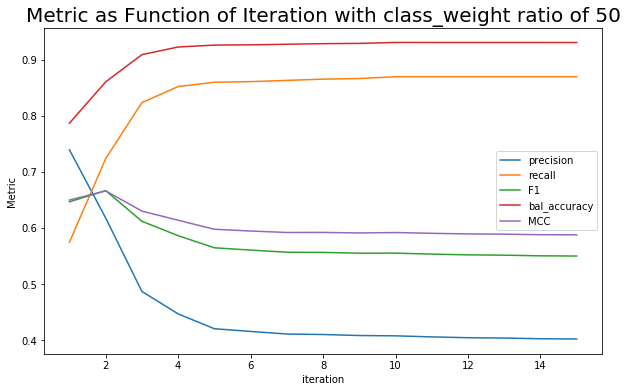

In [49]:
   
#replace NaN values with 0
recursive_frames_adj = []
for i in recursive_frames:
    recursive_frames_adj.append(i.fillna(0))

#plot performance
x_vals = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
precs_plt = [recursive_frames_adj[i-1].mean().precision for i in x_vals]
recs_plt = [recursive_frames_adj[i-1].mean().recall for i in x_vals]
f1s_plt = [recursive_frames_adj[i-1].mean().f1 for i in x_vals]
bal_acc_plt = [recursive_frames_adj[i-1].mean().bal_acc for i in x_vals]
matt_coeff_plt = [recursive_frames_adj[i-1].mean().matt_coef for i in x_vals]

plt.figure(figsize = (10,6))
plt.plot(x_vals, precs_plt,label= 'precision')
plt.plot(x_vals, recs_plt, label = 'recall')
plt.plot(x_vals, f1s_plt, label = 'F1')
plt.plot(x_vals, bal_acc_plt, label = 'bal_accuracy')
plt.plot(x_vals, matt_coeff_plt, label = 'MCC')
plt.xlabel('iteration')
plt.ylabel('Metric')
plt.title('Metric as Function of Iteration with class_weight ratio of '+str(weight_1), fontsize = 20)
plt.legend()
    
    
    

In [53]:
iteration_final[0]

,true_positives,false_positives,true_negatives,false_negatives,precision,recall,f1,f0.5,f2,bal_acc,matt_coef
0,792,1178,132289,119,0.40203,0.869374,0.549809,0.450461,0.705379,0.930274,0.587531


Feature ranking:
1. feature 4 (0.280051)
2. feature 2 (0.233492)
3. feature 6 (0.204176)
4. feature 3 (0.106397)
5. feature 5 (0.073073)
6. feature 1 (0.062187)
7. feature 0 (0.035476)
8. feature 7 (0.002124)
9. feature 9 (0.001665)
10. feature 8 (0.001359)


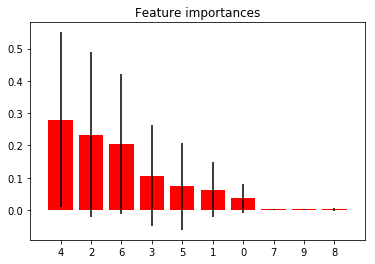

In [50]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train_scaled.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train_scaled.shape[1]), importances[indices],
        color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train_scaled.shape[1]), indices)
plt.xlim([-1, X_train_scaled.shape[1]])
plt.show()

Index(['ra', 'dec', 'pmra_x', 'pmdec_x', 'g', 'g_bp', 'g_rp', 'stream_mask',
       'ra_rad', 'dec_rad', 'ang_coord_1', 'ang_coord_2', 'ang_coord_3'],
      dtype='object')

In [55]:
testing_data['self_lab'] = np.where(testing_data.index.isin(self_labs[0].index),'True','False')

In [59]:
testing_data.to_csv('testing_gd1.csv')

In [48]:
iteration_1_adj = []
iteration_final_adj = []
for i in range(10):
    test = iteration_1[i]
    test2 = test.fillna(0)
    iteration_1_adj.append(test2)
    test = iteration_final[i]
    test2 = test.fillna(0)
    iteration_final_adj.append(test2)

In [57]:
x_vals = weight_1_ops
plt.figure(figsize=(10,6))

#initial iteration
iter_1_prec = [i.precision.mean() for i in iteration_1_adj]
iter_1_rec = [i.recall.mean() for i in iteration_1_adj]
iter_1_f1 = [i.f1.mean() for i in iteration_1_adj]

#final iteration
iter_final_prec = [i.precision.mean() for i in iteration_final_adj]
iter_final_rec = [i.recall.mean() for i in iteration_final_adj]
iter_final_f1 = [i.f1.mean() for i in iteration_final_adj]

plt.plot(x_vals, iter_1_prec, label = 'Precision_Init',color = 'b')
plt.plot(x_vals, iter_1_rec, label = 'Recall_Init',color = 'm')
plt.plot(x_vals, iter_1_f1, label = 'F1_Init',color = 'g')
plt.plot(x_vals, iter_final_prec, label = 'Precision_Final', color = 'b', linestyle='dashed')
plt.plot(x_vals, iter_final_rec, label = 'Recall_Final',color = 'm', linestyle='dashed')
plt.plot(x_vals, iter_final_f1, label = 'F1_Final',color = 'g', linestyle='dashed')
plt.xlabel('weight_options', fontsize=20)
plt.ylabel('metric', fontsize = 20)
plt.title('First and Final Iteration Metrics as a Function of Class_Weight', fontsize = 20)

plt.legend()

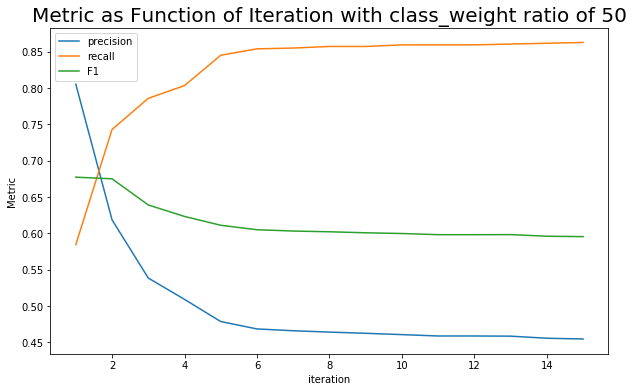

In [51]:
#replace NaN values with 0
recursive_frames_adj = []
for i in recursive_frames:
    recursive_frames_adj.append(i.fillna(0))

#plot performance
x_vals = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
precs_plt = [recursive_frames_adj[i-1].mean().precision for i in x_vals]
recs_plt = [recursive_frames_adj[i-1].mean().recall for i in x_vals]
f1s_plt = [recursive_frames_adj[i-1].mean().f1 for i in x_vals]

plt.figure(figsize = (10,6))
plt.plot(x_vals, precs_plt,label= 'precision')
plt.plot(x_vals, recs_plt, label = 'recall')
plt.plot(x_vals, f1s_plt, label = 'F1')
plt.xlabel('iteration')
plt.ylabel('Metric')
plt.title('Metric as Function of Iteration with class_weight ratio of '+str(weight_1), fontsize = 20)
plt.legend()

In [54]:
recursive_frames[0]

,true_positives,false_positives,true_negatives,false_negatives,precision,recall,f1,f1_prec_10,f1_prec_5,f1_rec_5,f1_rec_10
0,533,129,133500,379,0.805136,0.58443,0.677255,0.802137,0.793609,0.590657,0.58602


In [55]:
recursive_frames[14]

,true_positives,false_positives,true_negatives,false_negatives,precision,recall,f1,f1_prec_10,f1_prec_5,f1_rec_5,f1_rec_10
0,785,942,132545,125,0.454545,0.862637,0.595374,0.456685,0.462969,0.833844,0.855037


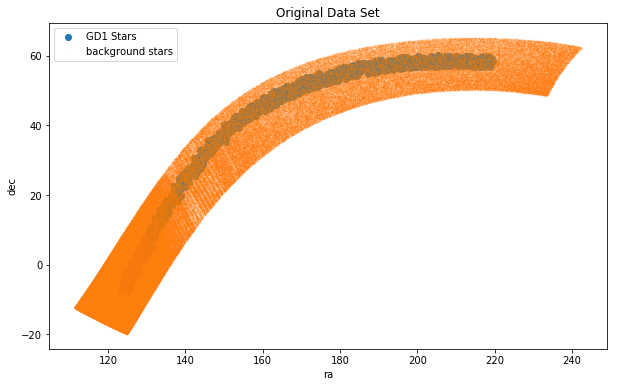

In [51]:
plt.figure(figsize=(10,6))
plt.scatter(dataset_gd1['ra'],dataset_gd1['dec'], label = 'GD1 Stars')
plt.scatter(dataset_nongd['ra'], dataset_nongd['dec'], label = 'background stars', s = 0.1, alpha = 0.2)
plt.title('Original Data Set')
plt.xlabel("ra")
plt.ylabel("dec")
plt.legend()

Text(0.5, 1.0, 'Original Training vs. Added Stars')

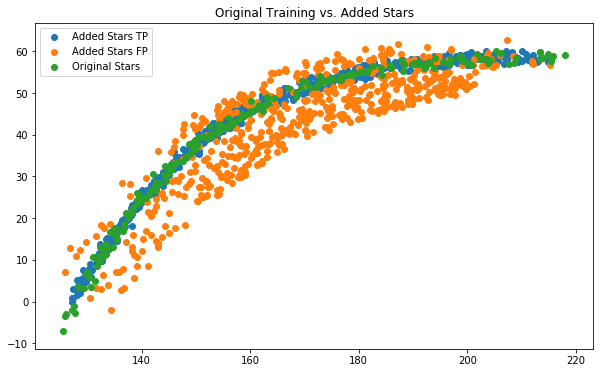

In [81]:
#X_added = X_correct_cum.append(X2_incorrect_cum, ignore_index = False, sort = False)
plt.figure(figsize=(10,6))
plt.scatter(X_correct_cum['ra'], X_correct_cum['dec'], label = 'Added Stars TP')
plt.scatter(X2_incorrect_cum['ra'], X2_incorrect_cum['dec'], label = 'Added Stars FP')
plt.scatter(stream_train_gd1['ra'], stream_train_gd1['dec'], label = 'Original Stars')
plt.legend()
plt.title('Original Training vs. Added Stars')

In [82]:
len(X_correct_cum), len(X2_incorrect_cum), len(X_incorrect_cum), len(X2_correct_cum), len(X_added), len(correct_X), len(incorrect_X2)

(731, 541, 649, 133573, 1272, 1, 1)

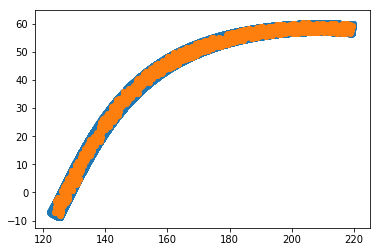

In [67]:
plt.scatter(X2_correct['ra'], X2_correct['dec'])
plt.scatter(X_incorrect['ra'], X_incorrect['dec'])

# Tune Random Forest model

In [41]:
#tuning for threshold
params= []
f1_vals = []

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 300, num = 3)] #start= 200,stop = 2000, num = 10
# Number of features to consider at every split
max_features = ['auto'] #'sqrt'
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 50, num = 3)] #10,110, num = 11
#max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2,5] #2,5,10
# Minimum number of samples required at each leaf node
min_samples_leaf = [1,2] #1,2,4
# Method of selecting samples for training each tree
bootstrap = [True] #False

total = 3 * 1 * 3 * 2 * 2 * 1
count = 0

for n_estimator in tqdm(n_estimators):
    for max_feature in max_features:
        for depth in max_depth:
            for min_split in min_samples_split:
                for min_leaf in min_samples_leaf:
                    for bootstrap_option in bootstrap:
                        count += 1
                        stream_name_rf = []
                        true_positives = []
                        false_positives = []
                        true_negatives = []
                        false_negatives = []
                        y_preds = []
                        testing_datas = []
                        multiple = 150

                        for stream_name in viable_new[:9]:

                            stream_primer1 = 'stream_stars_split/train_known/' + stream_name + "_known_to_model.csv"
                            stream_primer2 = 'stream_stars_split/test_unknown/' + stream_name + "_unknown_to_model.csv"

                            #stars known to model
                            stream_train = pd.read_csv(stream_primer1, index_col = 0)
                            stream_train['stream_mask'] = True
                            #unknown to model
                            stream_test = pd.read_csv(stream_primer2, index_col = 0)
                            stream_test['stream_mask'] = True  

                            #obtain noise points such that:
                            #- the ratio of stream to noise points in the training set is 1:multiple
                            #- the ratio of stream to noise points in the test set is close to the 'real' ratio
                            test_primer = 'stream_stars_split/simulated_noise_points/150_to_1_ratio/'
                            name_test = test_primer + stream_name + "_mul_150_total_noise.csv"

                            train_primer = 'stream_stars_split/simulated_noise_points/400_to_1_ratio/'
                            name_train = train_primer + stream_name + "_mul_400_total_noise.csv"

                            noise_test = pd.read_csv(name_test, index_col = 0)
                            noise_points = pd.read_csv(name_train, index_col = 0)

                            #add back the test points into the muck and assume they're background stars from which to draw
                            noise_points = noise_points.append(stream_test, ignore_index = False, sort = True)
                            train_points = len(stream_train) * multiple

                            #label our data as "not part of the stream"
                            noise_points['stream_mask'] = False

                            msk2 = np.random.rand(len(noise_points)) < (train_points / len(noise_points))
                            noise_train = noise_points[msk2]
                            #noise_test = noise_points[~msk2]



                            #combine my stream and noise to obtain complete training and test data set
                            training_data = stream_train.append(noise_train, ignore_index = False, sort = True)
                            training_data = training_data[['ra', 'dec', 'pmra', 'pmdec', 'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag', 'stream_mask']]

                            testing_data = stream_test.append(noise_test, ignore_index = False, sort = True)
                            testing_data = testing_data[['ra', 'dec', 'pmra', 'pmdec',  'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag', 'stream_mask']]

                            #Convert to Angular Coordinates
                            #ang_coord_1 = -pmdec * cos(ra) - pmra * cos(dec) * sin(dec) * sin(ra)
                            #ang_coord_2 = -pmra * cos(dec) * cos(ra) * sin(dec) + pmdec * sin(ra)
                            #ang_coord_3 =  pmra ( cos(dec) * cos(dec) )

                            deg2rad = lambda deg: deg/180.*np.pi

                            #Convert data to angular velocities
                            training_data['ra_rad'] = deg2rad(training_data['ra'])
                            training_data['dec_rad'] = deg2rad(training_data['dec'])

                            training_data['ang_coord_1'] = -1 * training_data.pmdec * ( np.cos(training_data.ra_rad)) -  training_data.pmdec * np.cos(training_data.dec_rad) * np.sin(training_data.dec_rad * np.sin(training_data.ra_rad))
                            training_data['ang_coord_2'] = -1 * training_data.pmra *    np.cos(training_data.dec_rad) * np.cos(training_data.ra_rad) * np.sin(training_data.dec_rad + training_data.pmra * np.sin(training_data.ra_rad))
                            training_data['ang_coord_3'] = training_data.pmra * ( np.cos(training_data.dec_rad) * np.cos(training_data.dec_rad) )

                            testing_data['ra_rad'] = deg2rad(testing_data['ra'])
                            testing_data['dec_rad'] = deg2rad(testing_data['dec'])

                            testing_data['ang_coord_1'] = -1 * testing_data.pmdec * ( np.cos(testing_data.ra_rad)) -  testing_data.pmdec * np.cos(testing_data.dec_rad) * np.sin(testing_data.dec_rad * np.sin(testing_data.ra_rad))
                            testing_data['ang_coord_2'] = -1 * testing_data.pmra *    np.cos(testing_data.dec_rad) * np.cos(testing_data.ra_rad) * np.sin(testing_data.dec_rad + testing_data.pmra * np.sin(testing_data.ra_rad))
                            testing_data['ang_coord_3'] = testing_data.pmra * ( np.cos(testing_data.dec_rad) * np.cos(testing_data.dec_rad) )


                            #differentiate training and test data's X and y variables
                            #X_train = training_data[['x', 'y', 'z', 'vx', 'vy', 'vz']] #[['ra', 'dec', 'pmra', 'pmdec']]
                            #y_train = training_data.stream_mask

                            #X_test = testing_data[['x', 'y', 'z', 'vx', 'vy', 'vz']] #[['ra', 'dec', 'pmra', 'pmdec']]
                            #y_test = testing_data.stream_mask


                            #differentiate training and test data's X and y variables
                            X_train = training_data[['ra', 'dec', 'pmra', 'pmdec','ang_coord_1', 'ang_coord_2', 'ang_coord_3', 'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag']]
                            y_train = training_data.stream_mask

                            X_test = testing_data[['ra', 'dec', 'pmra', 'pmdec','ang_coord_1', 'ang_coord_2', 'ang_coord_3', 'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag']]
                            y_test = testing_data.stream_mask


                            #scale the features using standard scaler (scaling not required for logistic regression)
                            scaler = StandardScaler()
                            X_train_scaled = scaler.fit(X_train).transform(X_train)
                            X_test_scaled = scaler.fit(X_test).transform(X_test)

                            precision, recall, accuracy, auc, y_pred, y_true = random_forest_model(X_train_scaled, X_test_scaled, y_train, y_test, 
                                                                                                   n_trees = n_estimator, criterion = "gini", max_depth = depth,
                                                                                                   min_samples_split = min_split, min_samples_leaf = min_leaf, 
                                                                                                   min_weight_fraction_leaf = 0, max_features = max_feature, 
                                                                                                   max_leaf_nodes = None, min_impurity_decrease = 0, 
                                                                                                   min_impurity_split = 1e-7, bootstrap = bootstrap_option,
                                                                                                   oob_score = False, n_jobs = 1, 
                                                                                                   random_state = None, verbose = 0, warm_start = False)


                            #y_test = results_use[streams_threshold_tuning[stream_index]].stream_mask
                            #y_pred = results_use[streams_threshold_tuning[stream_index]][col_name]
                            #Truly in Cluster
                            X_correct = testing_data[y_test & y_pred] #predicted in cluster (true positives)
                            X_incorrect = testing_data[y_test & ~y_pred] #predicted not in cluster (false negative)
                            #Truly not in Cluster
                            X2_correct = testing_data[~y_test & ~y_pred] #predicted not in cluster (true negative)
                            X2_incorrect = testing_data[~y_test & y_pred] #predicted in cluster (false positive)

                            stream_name_rf.append(stream_name)
                            true_positives.append(len(X_correct))
                            false_positives.append(len(X2_incorrect))
                            true_negatives.append(len(X2_correct))
                            false_negatives.append(len(X_incorrect))
                            y_preds.append(y_pred)
                            testing_datas.append(testing_data)
                            param = (n_estimator, max_feature, depth, min_split, min_leaf, bootstrap_option)
                            params.append(param)
                        if count%3 == 0:
                            print (str(count) + ' out of ' + str(total) + 'done')

                        final_result_rf = pd.DataFrame()
                        final_result_rf['stream']= stream_name_rf
                        final_result_rf['true_positives']=true_positives
                        final_result_rf['false_positives']=false_positives
                        final_result_rf['true_negatives']=true_negatives
                        final_result_rf['false_negatives']=false_negatives
                        #final_result['auc'] = aucs
                        final_result_rf['precision'] = final_result_rf.true_positives / (final_result_rf.true_positives + final_result_rf.false_positives)
                        final_result_rf['recall'] = final_result_rf.true_positives / (final_result_rf.true_positives + final_result_rf.false_negatives)
                        final_result_rf['f1'] = 2*(final_result_rf.precision * final_result_rf.recall)/(final_result_rf.precision + final_result_rf.recall)
                        beta = 0.1
                        final_result_rf['f1_prec_10'] = (1 + beta**2) * (final_result_rf.precision * final_result_rf.recall) / (beta**2 * final_result_rf.precision + final_result_rf.recall)
                        beta = 0.2
                        final_result_rf['f1_prec_5'] = (1 + beta**2) * (final_result_rf.precision * final_result_rf.recall) / (beta**2 * final_result_rf.precision + final_result_rf.recall)
                        beta = 5
                        final_result_rf['f1_rec_5'] = (1 + beta**2) * (final_result_rf.precision * final_result_rf.recall) / (beta**2 * final_result_rf.precision + final_result_rf.recall)
                        beta = 10
                        final_result_rf['f1_rec_10'] = (1 + beta**2) * (final_result_rf.precision * final_result_rf.recall) / (beta**2 * final_result_rf.precision + final_result_rf.recall)

                        f1_vals.append(final_result_rf[final_result_rf.index.isin(range(9))].f1.mean())

  0%|          | 0/3 [00:00<?, ?it/s]

3 out of 36done
3 out of 36done
3 out of 36done
3 out of 36done
3 out of 36done
3 out of 36done
3 out of 36done
3 out of 36done
3 out of 36done
6 out of 36done
6 out of 36done
6 out of 36done
6 out of 36done
6 out of 36done
6 out of 36done
6 out of 36done
6 out of 36done
6 out of 36done
9 out of 36done
9 out of 36done
9 out of 36done
9 out of 36done
9 out of 36done
9 out of 36done
9 out of 36done
9 out of 36done
9 out of 36done
12 out of 36done
12 out of 36done
12 out of 36done
12 out of 36done
12 out of 36done
12 out of 36done
12 out of 36done
12 out of 36done


 33%|███▎      | 1/3 [05:45<11:31, 345.67s/it]

12 out of 36done
15 out of 36done
15 out of 36done
15 out of 36done
15 out of 36done
15 out of 36done
15 out of 36done
15 out of 36done
15 out of 36done
15 out of 36done
18 out of 36done
18 out of 36done
18 out of 36done
18 out of 36done
18 out of 36done
18 out of 36done
18 out of 36done
18 out of 36done
18 out of 36done
21 out of 36done
21 out of 36done
21 out of 36done
21 out of 36done
21 out of 36done
21 out of 36done
21 out of 36done
21 out of 36done
21 out of 36done
24 out of 36done
24 out of 36done
24 out of 36done
24 out of 36done
24 out of 36done
24 out of 36done
24 out of 36done
24 out of 36done


 67%|██████▋   | 2/3 [15:00<06:48, 408.52s/it]

24 out of 36done
27 out of 36done
27 out of 36done
27 out of 36done
27 out of 36done
27 out of 36done
27 out of 36done
27 out of 36done
27 out of 36done
27 out of 36done
30 out of 36done
30 out of 36done
30 out of 36done
30 out of 36done
30 out of 36done
30 out of 36done
30 out of 36done
30 out of 36done
30 out of 36done
33 out of 36done
33 out of 36done
33 out of 36done
33 out of 36done
33 out of 36done
33 out of 36done
33 out of 36done
33 out of 36done
33 out of 36done
36 out of 36done
36 out of 36done
36 out of 36done
36 out of 36done
36 out of 36done
36 out of 36done
36 out of 36done
36 out of 36done


100%|██████████| 3/3 [27:52<00:00, 517.56s/it]

36 out of 36done


In [45]:
params_opt = params[f1_vals.index(max(f1_vals))]
print(params_opt)
print(max(f1_vals))

(100, 'auto', 10, 5, 1, True)
0.695986056049877


# Test Random Forest model

## Iteration 2 (Recursion)

In [27]:
def rf_recursion(training_streams, testing_streams, correct_X, incorrect_X2, self_labs, final_result_rf, plot_permit):

    stream_name_rf = []
    true_positives = []
    false_positives = []
    true_negatives = []
    false_negatives = []
    y_preds = []
    testing_datas = []
    training_datas = []
    multiple = 150

    weight_1_options = [0.01, 0.05, 0.1, 0.2, 0.5, 1,5,10,20,50,100,150,200,250,300,400,500,750,1000,2000]
    precisions = []
    recalls = []
    f1s_weights = []

    training_streams_2 = []
    testing_streams_2 = []
    correct_X_2 = []
    incorrect_X2_2 = []
    self_labs_2 = []

    original_index = -1

    #for weight_1 in tqdm(weight_1_options):
    for stream_name in tqdm(viable_new2):
        original_index += 1
        stream_train_prev = training_streams[original_index]
        stream_test_prev = testing_streams[original_index]
        X_correct_prev = correct_X[original_index]
        X2_incorrect_prev = incorrect_X2[original_index]


    #     stellar_stream = pd.read_csv('stream_stars_split/group_c_intelligent/'+stream_name+ '_intelligent_cut.csv')
    #     stellar_stream_valid_b = stellar_stream[stellar_stream['meets_b_req']==True]
    #     #stream_primer1 = 'stream_stars_split/train_known/' + stream_name + "_known_to_model.csv"
    #     #stream_primer2 = 'stream_stars_split/test_unknown/' + stream_name + "_unknown_to_model.csv"

        #stars known to model
        stream_train2 = stream_train_prev.append(stream_test_prev[stream_test_prev.index.isin(X_correct_prev.index)], ignore_index = False)
        stream_train2 = stream_train2.append(stream_test_prev[stream_test_prev.index.isin(X2_incorrect_prev.index)], ignore_index = False)
        stream_train2['stream_mask'] = True

        #unknown to model
        stream_test2 = stream_test_prev[~stream_test_prev.index.isin(X_correct_prev.index)]
        stream_test2['stream_mask'] = True  

        #obtain noise points such that:
        #- the ratio of stream to noise points in the training set is 1:multiple
        #- the ratio of stream to noise points in the test set is close to the 'real' ratio
        test_primer = 'stream_stars_split/simulated_noise_points/ratios_intelligent/'
        name_test = test_primer + stream_name + "_mul_150_total_noise.csv"

        train_primer = 'stream_stars_split/simulated_noise_points/ratios_intelligent/'
        name_train = train_primer + stream_name + "_mul_400_total_noise.csv"

        noise_test = pd.read_csv(name_test, index_col = 0)
        noise_points = pd.read_csv(name_train, index_col = 0)

        #add back the test points into the muck and assume they're background stars from which to draw
        noise_points = noise_points.append(stream_test2, ignore_index = False)
        train_points = len(stream_train2) * multiple

        #label our data as "not part of the stream"
        noise_points['stream_mask'] = False

        msk2 = np.random.rand(len(noise_points)) < (train_points / len(noise_points))
        noise_train = noise_points[msk2]
        #noise_test = noise_points[~msk2]

        #combine my stream and noise to obtain complete training and test data set
        training_data = stream_train2.append(noise_train, ignore_index = False)
        training_data = training_data[['ra', 'dec', 'pmra', 'pmdec', 'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag', 'stream_mask']]

        testing_data = stream_test2.append(noise_test, ignore_index = False)
        testing_data = testing_data[['ra', 'dec', 'pmra', 'pmdec',  'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag', 'stream_mask']]

        testing_data = self_labs[original_index]
        testing_data = testing_data[~testing_data.index.isin(X_correct_prev.index)] #TP
        testing_data = testing_data[~testing_data.index.isin(X2_incorrect_prev.index)] #FP

        #Convert to Angular Coordinates
        #ang_coord_1 = -pmdec * cos(ra) - pmra * cos(dec) * sin(dec) * sin(ra)
        #ang_coord_2 = -pmra * cos(dec) * cos(ra) * sin(dec) + pmdec * sin(ra)
        #ang_coord_3 =  pmra ( cos(dec) * cos(dec) )

        deg2rad = lambda deg: deg/180.*np.pi

        #Convert data to angular velocities
        training_data['ra_rad'] = deg2rad(training_data['ra'])
        training_data['dec_rad'] = deg2rad(training_data['dec'])

        training_data['ang_coord_1'] = -1 * training_data.pmdec * ( np.cos(training_data.ra_rad)) -  training_data.pmdec * np.cos(training_data.dec_rad) * np.sin(training_data.dec_rad * np.sin(training_data.ra_rad))
        training_data['ang_coord_2'] = -1 * training_data.pmra *    np.cos(training_data.dec_rad) * np.cos(training_data.ra_rad) * np.sin(training_data.dec_rad + training_data.pmra * np.sin(training_data.ra_rad))
        training_data['ang_coord_3'] = training_data.pmra * ( np.cos(training_data.dec_rad) * np.cos(training_data.dec_rad) )


        testing_data['ra_rad'] = deg2rad(testing_data['ra'])
        testing_data['dec_rad'] = deg2rad(testing_data['dec'])

        testing_data['ang_coord_1'] = -1 * testing_data.pmdec * ( np.cos(testing_data.ra_rad)) -  testing_data.pmdec * np.cos(testing_data.dec_rad) * np.sin(testing_data.dec_rad * np.sin(testing_data.ra_rad))
        testing_data['ang_coord_2'] = -1 * testing_data.pmra *    np.cos(testing_data.dec_rad) * np.cos(testing_data.ra_rad) * np.sin(testing_data.dec_rad + testing_data.pmra * np.sin(testing_data.ra_rad))
        testing_data['ang_coord_3'] = testing_data.pmra * ( np.cos(testing_data.dec_rad) * np.cos(testing_data.dec_rad) )

        self_labs_2.append(testing_data)


        #differentiate training and test data's X and y variables
        #X_train = training_data[['x', 'y', 'z', 'vx', 'vy', 'vz']] #[['ra', 'dec', 'pmra', 'pmdec']]
        #y_train = training_data.stream_mask

        #X_test = testing_data[['x', 'y', 'z', 'vx', 'vy', 'vz']] #[['ra', 'dec', 'pmra', 'pmdec']]
        #y_test = testing_data.stream_mask


        #differentiate training and test data's X and y variables
        #X_train = training_data[['ra', 'dec', 'pmra', 'pmdec', 'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag']]
        X_train = training_data[['ra', 'dec', 'pmra', 'pmdec', 'ang_coord_1', 'ang_coord_2', 'ang_coord_3', 'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag']]
        y_train = training_data.stream_mask

        #X_test = testing_data[['ra', 'dec', 'pmra', 'pmdec', 'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag']]
        X_test = testing_data[['ra', 'dec', 'pmra', 'pmdec','ang_coord_1', 'ang_coord_2', 'ang_coord_3', 'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag']]
        y_test = testing_data.stream_mask


        #scale the features using standard scaler (scaling not required for logistic regression)
        scaler = StandardScaler()
        X_train_scaled = scaler.fit(X_train).transform(X_train)
        X_test_scaled = scaler.fit(X_train).transform(X_test)


        #use mean square sum for angular velocity (wx/N, wy/N, wz/N), where N = sqrt(wx^2 + wy^2 + wz^2)
    #     X_train_scaled = pd.DataFrame(X_train_scaled, columns = ['ra', 'dec', 'pmra', 'pmdec','ang_coord_1', 'ang_coord_2', 'ang_coord_3', 'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag'])
    #     X_test_scaled = pd.DataFrame(X_test_scaled, columns = ['ra', 'dec', 'pmra', 'pmdec','ang_coord_1', 'ang_coord_2', 'ang_coord_3', 'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag']) 

    #     X_train_scaled['mean_square_sum'] = X_train_scaled['ang_coord_1']**2+X_train_scaled['ang_coord_2']**2+X_train_scaled['ang_coord_3']**2
    #     X_train_scaled['ang_coord_1'] = X_train_scaled['ang_coord_1'] / X_train_scaled['mean_square_sum']
    #     X_train_scaled['ang_coord_2'] = X_train_scaled['ang_coord_2'] / X_train_scaled['mean_square_sum']
    #     X_train_scaled['ang_coord_3'] = X_train_scaled['ang_coord_3'] / X_train_scaled['mean_square_sum']
    #     X_train_scaled = X_train_scaled.drop(['mean_square_sum'], axis = 1)
    #     X_train_scaled = np.array(X_train_scaled)

    #     X_test_scaled['mean_square_sum'] = X_test_scaled['ang_coord_1']**2+X_test_scaled['ang_coord_2']**2+X_test_scaled['ang_coord_3']**2
    #     X_test_scaled['ang_coord_1'] = X_test_scaled['ang_coord_1'] / X_test_scaled['mean_square_sum']
    #     X_test_scaled['ang_coord_2'] = X_test_scaled['ang_coord_2'] / X_test_scaled['mean_square_sum']
    #     X_test_scaled['ang_coord_3'] = X_test_scaled['ang_coord_3'] / X_test_scaled['mean_square_sum']
    #     X_test_scaled = X_test_scaled.drop(['mean_square_sum'], axis = 1)
    #     X_test_scaled = np.array(X_test_scaled)    

        precision, recall, accuracy, auc, y_pred, y_true, forest = random_forest_model(X_train_scaled, X_test_scaled, y_train, y_test, 
                                                                               n_trees = n_estimator_opt, criterion = "gini", max_depth = depth_opt,
                                                                               min_samples_split = min_split_opt, min_samples_leaf = min_leaf_opt, 
                                                                               min_weight_fraction_leaf = 0, max_features = max_feature_opt, 
                                                                               max_leaf_nodes = None, 
                                                                               min_impurity_split = 1e-7, bootstrap = bootstrap_opt,
                                                                               oob_score = False, n_jobs = 1, 
                                                                               random_state = None, verbose = 0, warm_start = False, class_weight = {0:weight_0,1:weight_1})


        #y_test = results_use[streams_threshold_tuning[stream_index]].stream_mask
        #y_pred = results_use[streams_threshold_tuning[stream_index]][col_name]
        #Truly in Cluster
        X_correct = testing_data[y_test & y_pred] #predicted in cluster (true positives)
        X_incorrect = testing_data[y_test & ~y_pred] #predicted not in cluster (false negative)
        #Truly not in Cluster
        X2_correct = testing_data[~y_test & ~y_pred] #predicted not in cluster (true negative)
        X2_incorrect = testing_data[~y_test & y_pred] #predicted in cluster (false positive)
        
        X_correct_cum.append(X_correct, ignore_index = False)
        X_incorrect_cum.append(X_incorrect, ignore_index = False)
        #X2_correct_cum.append(X2_correct, ignore_index = False, sort = True)
        #X2_incorrect_cum.append(X2_incorrect, ignore_index = False, sort = True)
        
#         if plot_permit == 'yes':
#             X_correct_cum['species']='TP'
#             X_incorrect_cum['species']='FN'
#             X2_incorrect['species']='FP'

#             sns_frame = X_correct_cum.append(X_incorrect_cum, ignore_index = False)
#             sns_frame = sns_frame.append(X2_incorrect, ignore_index = False)

#             sns_frame = sns_frame[['ra','dec','pmra','pmdec', 'ang_coord_1', 'ang_coord_2', 'ang_coord_3', 'species']]

#             g = sns.pairplot(sns_frame, hue = 'species')
#             g.fig.suptitle('Pairwise Plot for ' + stream_name, y = 1.08)
        
        stream_name_rf.append(stream_name)
        true_positives.append(len(X_correct))
        false_positives.append(len(X2_incorrect))
        true_negatives.append(len(X2_correct))
        false_negatives.append(len(X_incorrect))
        y_preds.append(y_pred)
        testing_datas.append(testing_data)
        training_datas.append(training_data)
        training_streams_2.append(stream_train2)
        testing_streams_2.append(stream_test2)
        correct_X_2.append(X_correct)
        incorrect_X2_2.append(X2_incorrect)

    final_result_rf2 = pd.DataFrame()
    final_result_rf2['stream']= stream_name_rf
    final_result_rf2['true_positives']=true_positives+recursive_frames[(len(recursive_frames)-1)].true_positives
    final_result_rf2['false_positives']=false_positives+recursive_frames[(len(recursive_frames)-1)].false_positives
    final_result_rf2['true_negatives']=true_negatives
    final_result_rf2['false_negatives']=false_negatives
    #final_result['auc'] = aucs
    final_result_rf2['precision'] = final_result_rf2.true_positives / (final_result_rf2.true_positives + final_result_rf2.false_positives)
    final_result_rf2['recall'] = final_result_rf2.true_positives / (final_result_rf2.true_positives + final_result_rf2.false_negatives)
    final_result_rf2['f1'] = 2*(final_result_rf2.precision * final_result_rf2.recall)/(final_result_rf2.precision + final_result_rf2.recall)
    beta = 0.1
    final_result_rf2['f1_prec_10'] = (1 + beta**2) * (final_result_rf2.precision * final_result_rf2.recall) / (beta**2 * final_result_rf2.precision + final_result_rf2.recall)
    beta = 0.2
    final_result_rf2['f1_prec_5'] = (1 + beta**2) * (final_result_rf2.precision * final_result_rf2.recall) / (beta**2 * final_result_rf2.precision + final_result_rf2.recall)
    beta = 5
    final_result_rf2['f1_rec_5'] = (1 + beta**2) * (final_result_rf2.precision * final_result_rf2.recall) / (beta**2 * final_result_rf2.precision + final_result_rf2.recall)
    beta = 10
    final_result_rf2['f1_rec_10'] = (1 + beta**2) * (final_result_rf2.precision * final_result_rf2.recall) / (beta**2 * final_result_rf2.precision + final_result_rf2.recall)

    #     precisions.append(final_result_rf.mean().precision)
    #     recalls.append(final_result_rf.mean().recall)
    #     f1s_weights.append(final_result_rf.mean().f1)

    #     recursive_frames.append(final_result_rf2)

    return training_streams_2, testing_streams_2, correct_X_2, incorrect_X2_2, self_labs_2, final_result_rf2
    

In [28]:
# #define optimal parameters
# n_estimator_opt = params_opt[0]
# max_feature_opt = params_opt[1]
# depth_opt = params_opt[2]
# min_split_opt = params_opt[3]
# min_leaf_opt = params_opt[4]
# bootstrap_opt = params_opt[5]
iteration_1 = []
iteration_final = []

weight_1_ops = [1,5,10,25,50,100,150,250,400,500] #all options
#weight_1_ops = [150]

for weight_1_option in tqdm(weight_1_ops):
    n_estimator_opt = 200
    max_feature_opt = 'auto'
    depth_opt = 10
    min_split_opt = 2
    min_leaf_opt = 1
    bootstrap_opt = True
    weight_0 = 1
    weight_1 = weight_1_option #high precision model has this = 1; alternatively, balanced model has this = 500

    viable_new2 = viable_new[9:16]+viable_new[17:]
    viable_new2

    recursive_frames = []

    stream_name_rf = []
    true_positives = []
    false_positives = []
    true_negatives = []
    false_negatives = []
    y_preds = []
    testing_datas = []
    training_datas = []
    multiple = 150
    self_labs = []

    precisions = []
    recalls = []
    f1s_weights = []

    training_streams = []
    testing_streams = []
    correct_X = []
    incorrect_X2 = []

    for stream_name in tqdm(viable_new2):

        stellar_stream = pd.read_csv('stream_stars_split/group_c_intelligent/'+stream_name+ '_intelligent_cut.csv')
        stellar_stream_valid_b = stellar_stream[stellar_stream['meets_b_req']==True]
        #stream_primer1 = 'stream_stars_split/train_known/' + stream_name + "_known_to_model.csv"
        #stream_primer2 = 'stream_stars_split/test_unknown/' + stream_name + "_unknown_to_model.csv"

        #stars known to model
        stream_train = stellar_stream_valid_b[stellar_stream_valid_b.known_to_model==True]
        stream_train['stream_mask'] = True
        #unknown to model
        stream_test = stellar_stream_valid_b[stellar_stream_valid_b.known_to_model==False]
        stream_test['stream_mask'] = True  

        #obtain noise points such that:
        #- the ratio of stream to noise points in the training set is 1:multiple
        #- the ratio of stream to noise points in the test set is close to the 'real' ratio
        test_primer = 'stream_stars_split/simulated_noise_points/ratios_intelligent/'
        name_test = test_primer + stream_name + "_mul_150_total_noise.csv"

        train_primer = 'stream_stars_split/simulated_noise_points/ratios_intelligent/'
        name_train = train_primer + stream_name + "_mul_400_total_noise.csv"

        noise_test = pd.read_csv(name_test, index_col = 0)
        noise_points = pd.read_csv(name_train, index_col = 0)

        #add back the test points into the muck and assume they're background stars from which to draw
        noise_points = noise_points.append(stream_test, ignore_index = False)
        #train_points = len(stream_train) * multiple
        train_points = len(stream_train) * multiple

        #label our data as "not part of the stream"
        noise_points['stream_mask'] = False

        msk2 = np.random.rand(len(noise_points)) < (train_points / len(noise_points))
        noise_train = noise_points[msk2]
        #noise_test = noise_points[~msk2]



        #combine my stream and noise to obtain complete training and test data set
        training_data = stream_train.append(noise_train, ignore_index = False)
        training_data = training_data[['ra', 'dec', 'pmra', 'pmdec', 'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag', 'stream_mask']]

        testing_data = stream_test.append(noise_test, ignore_index = False)
        testing_data = testing_data[['ra', 'dec', 'pmra', 'pmdec',  'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag', 'stream_mask']]

        #Convert to Angular Coordinates
        #ang_coord_1 = -pmdec * cos(ra) - pmra * cos(dec) * sin(dec) * sin(ra)
        #ang_coord_2 = -pmra * cos(dec) * cos(ra) * sin(dec) + pmdec * sin(ra)
        #ang_coord_3 =  pmra ( cos(dec) * cos(dec) )

        deg2rad = lambda deg: deg/180.*np.pi

        #Convert data to angular velocities
        training_data['ra_rad'] = deg2rad(training_data['ra'])
        training_data['dec_rad'] = deg2rad(training_data['dec'])

        training_data['ang_coord_1'] = -1 * training_data.pmdec * ( np.cos(training_data.ra_rad)) -  training_data.pmdec * np.cos(training_data.dec_rad) * np.sin(training_data.dec_rad * np.sin(training_data.ra_rad))
        training_data['ang_coord_2'] = -1 * training_data.pmra *    np.cos(training_data.dec_rad) * np.cos(training_data.ra_rad) * np.sin(training_data.dec_rad + training_data.pmra * np.sin(training_data.ra_rad))
        training_data['ang_coord_3'] = training_data.pmra * ( np.cos(training_data.dec_rad) * np.cos(training_data.dec_rad) )

        testing_data['ra_rad'] = deg2rad(testing_data['ra'])
        testing_data['dec_rad'] = deg2rad(testing_data['dec'])

        testing_data['ang_coord_1'] = -1 * testing_data.pmdec * ( np.cos(testing_data.ra_rad)) -  testing_data.pmdec * np.cos(testing_data.dec_rad) * np.sin(testing_data.dec_rad * np.sin(testing_data.ra_rad))
        testing_data['ang_coord_2'] = -1 * testing_data.pmra *    np.cos(testing_data.dec_rad) * np.cos(testing_data.ra_rad) * np.sin(testing_data.dec_rad + testing_data.pmra * np.sin(testing_data.ra_rad))
        testing_data['ang_coord_3'] = testing_data.pmra * ( np.cos(testing_data.dec_rad) * np.cos(testing_data.dec_rad) )

        testing_data_eval, testing_data_selflab = train_test_split(testing_data, test_size=0.5)
        self_labs.append(testing_data_selflab)

        #differentiate training and test data's X and y variables
        #X_train = training_data[['x', 'y', 'z', 'vx', 'vy', 'vz']] #[['ra', 'dec', 'pmra', 'pmdec']]
        #y_train = training_data.stream_mask

        #X_test = testing_data[['x', 'y', 'z', 'vx', 'vy', 'vz']] #[['ra', 'dec', 'pmra', 'pmdec']]
        #y_test = testing_data.stream_mask


        #differentiate training and test data's X and y variables
        #X_train = training_data[['ra', 'dec', 'pmra', 'pmdec', 'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag']]
        X_train = training_data[['ra', 'dec', 'pmra', 'pmdec', 'ang_coord_1', 'ang_coord_2', 'ang_coord_3', 'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag']]
        y_train = training_data.stream_mask

        ##eval
        #X_test = testing_data_eval[['ra', 'dec', 'pmra', 'pmdec', 'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag']]
        X_test_eval = testing_data_eval[['ra', 'dec', 'pmra', 'pmdec','ang_coord_1', 'ang_coord_2', 'ang_coord_3', 'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag']]
        y_test_eval = testing_data_eval.stream_mask

        ##self_lab
        #X_test = testing_data_selflab[['ra', 'dec', 'pmra', 'pmdec', 'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag']]
        X_test_selflab = testing_data_selflab[['ra', 'dec', 'pmra', 'pmdec','ang_coord_1', 'ang_coord_2', 'ang_coord_3', 'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag']]
        y_test_selflab = testing_data_selflab.stream_mask


        #scale the features using standard scaler (scaling not required for logistic regression)
        scaler = StandardScaler()
        X_train_scaled = scaler.fit(X_train).transform(X_train)
        X_test_scaled_eval = scaler.fit(X_train).transform(X_test_eval)
        X_test_scaled_selflab = scaler.fit(X_train).transform(X_test_selflab)




        #use mean square sum for angular velocity (wx/N, wy/N, wz/N), where N = sqrt(wx^2 + wy^2 + wz^2)
    #     X_train_scaled = pd.DataFrame(X_train_scaled, columns = ['ra', 'dec', 'pmra', 'pmdec','ang_coord_1', 'ang_coord_2', 'ang_coord_3', 'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag'])
    #     X_test_scaled = pd.DataFrame(X_test_scaled, columns = ['ra', 'dec', 'pmra', 'pmdec','ang_coord_1', 'ang_coord_2', 'ang_coord_3', 'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag']) 

    #     X_train_scaled['mean_square_sum'] = X_train_scaled['ang_coord_1']**2+X_train_scaled['ang_coord_2']**2+X_train_scaled['ang_coord_3']**2
    #     X_train_scaled['ang_coord_1'] = X_train_scaled['ang_coord_1'] / X_train_scaled['mean_square_sum']
    #     X_train_scaled['ang_coord_2'] = X_train_scaled['ang_coord_2'] / X_train_scaled['mean_square_sum']
    #     X_train_scaled['ang_coord_3'] = X_train_scaled['ang_coord_3'] / X_train_scaled['mean_square_sum']
    #     X_train_scaled = X_train_scaled.drop(['mean_square_sum'], axis = 1)
    #     X_train_scaled = np.array(X_train_scaled)

    #     X_test_scaled['mean_square_sum'] = X_test_scaled['ang_coord_1']**2+X_test_scaled['ang_coord_2']**2+X_test_scaled['ang_coord_3']**2
    #     X_test_scaled['ang_coord_1'] = X_test_scaled['ang_coord_1'] / X_test_scaled['mean_square_sum']
    #     X_test_scaled['ang_coord_2'] = X_test_scaled['ang_coord_2'] / X_test_scaled['mean_square_sum']
    #     X_test_scaled['ang_coord_3'] = X_test_scaled['ang_coord_3'] / X_test_scaled['mean_square_sum']
    #     X_test_scaled = X_test_scaled.drop(['mean_square_sum'], axis = 1)
    #     X_test_scaled = np.array(X_test_scaled)    

        precision, recall, accuracy, auc, y_pred, y_true, forest = random_forest_model(X_train_scaled, X_test_scaled_selflab, y_train, y_test_selflab, 
                                                                               n_trees = n_estimator_opt, criterion = "gini", max_depth = depth_opt,
                                                                               min_samples_split = min_split_opt, min_samples_leaf = min_leaf_opt, 
                                                                               min_weight_fraction_leaf = 0, max_features = max_feature_opt, 
                                                                               max_leaf_nodes = None, 
                                                                               min_impurity_split = 1e-7, bootstrap = bootstrap_opt,
                                                                               oob_score = False, n_jobs = 1, 
                                                                               random_state = None, verbose = 0, warm_start = False, class_weight = {0:weight_0,1:weight_1}) #"balanced"


        #y_test = results_use[streams_threshold_tuning[stream_index]].stream_mask
        #y_pred = results_use[streams_threshold_tuning[stream_index]][col_name]
        #Truly in Cluster
        X_correct = testing_data_selflab[y_test_selflab & y_pred] #predicted in cluster (true positives)
        X_incorrect = testing_data_selflab[y_test_selflab & ~y_pred] #predicted not in cluster (false negative)
        #Truly not in Cluster
        X2_correct = testing_data_selflab[~y_test_selflab & ~y_pred] #predicted not in cluster (true negative)
        X2_incorrect = testing_data_selflab[~y_test_selflab & y_pred] #predicted in cluster (false positive)
        
        X_correct_cum = X_correct
        X_incorrect_cum = X_incorrect
        X2_correct_cum = X2_correct
        X2_incorrect_cum = X2_incorrect
        
        stream_name_rf.append(stream_name)
        true_positives.append(len(X_correct))
        false_positives.append(len(X2_incorrect))
        true_negatives.append(len(X2_correct))
        false_negatives.append(len(X_incorrect))
        y_preds.append(y_pred)
        testing_datas.append(testing_data_selflab)
        training_datas.append(training_data)
        training_streams.append(stream_train)
        testing_streams.append(stream_test)
        correct_X.append(X_correct)
        incorrect_X2.append(X2_incorrect)

    final_result_rf = pd.DataFrame()
    final_result_rf['stream']= stream_name_rf
    final_result_rf['true_positives']=true_positives
    final_result_rf['false_positives']=false_positives
    final_result_rf['true_negatives']=true_negatives
    final_result_rf['false_negatives']=false_negatives
    #final_result['auc'] = aucs
    final_result_rf['precision'] = final_result_rf.true_positives / (final_result_rf.true_positives + final_result_rf.false_positives)
    final_result_rf['recall'] = final_result_rf.true_positives / (final_result_rf.true_positives + final_result_rf.false_negatives)
    final_result_rf['f1'] = 2*(final_result_rf.precision * final_result_rf.recall)/(final_result_rf.precision + final_result_rf.recall)
    beta = 0.1
    final_result_rf['f1_prec_10'] = (1 + beta**2) * (final_result_rf.precision * final_result_rf.recall) / (beta**2 * final_result_rf.precision + final_result_rf.recall)
    beta = 0.2
    final_result_rf['f1_prec_5'] = (1 + beta**2) * (final_result_rf.precision * final_result_rf.recall) / (beta**2 * final_result_rf.precision + final_result_rf.recall)
    beta = 5
    final_result_rf['f1_rec_5'] = (1 + beta**2) * (final_result_rf.precision * final_result_rf.recall) / (beta**2 * final_result_rf.precision + final_result_rf.recall)
    beta = 10
    final_result_rf['f1_rec_10'] = (1 + beta**2) * (final_result_rf.precision * final_result_rf.recall) / (beta**2 * final_result_rf.precision + final_result_rf.recall)

    recursive_frames.append(final_result_rf)
    iteration_1.append(final_result_rf)

    #do the recursion more times
    for i in range(1,15): #do it 14 more times
        plot_permit = 'no'
        #if i == 14:
        #    plot_permit = 'yes'
        training_streams, testing_streams, correct_X, incorrect_X2, self_labs, final_result_rf_updated = rf_recursion(training_streams, testing_streams, correct_X, incorrect_X2, self_labs, final_result_rf, plot_permit)
        recursive_frames.append(final_result_rf_updated)
    iteration_final.append(final_result_rf_updated)
    
#     #replace NaN values with 0
#     recursive_frames_adj = []
#     for i in recursive_frames:
#         recursive_frames_adj.append(i.fillna(0))

#     #plot performance
#     x_vals = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
#     precs_plt = [recursive_frames_adj[i-1].mean().precision for i in x_vals]
#     recs_plt = [recursive_frames_adj[i-1].mean().recall for i in x_vals]
#     f1s_plt = [recursive_frames_adj[i-1].mean().f1 for i in x_vals]

#     plt.figure(figsize = (10,6))
#     plt.plot(x_vals, precs_plt,label= 'precision')
#     plt.plot(x_vals, recs_plt, label = 'recall')
#     plt.plot(x_vals, f1s_plt, label = 'F1')
#     plt.xlabel('iteration')
#     plt.ylabel('Metric')
#     plt.title('Metric as Function of Iteration with class_weight ratio of '+str(weight_1), fontsize = 20)
#     plt.legend()

100%|██████████| 8/8 [00:16<00:00,  2.85s/it]

100%|██████████| 8/8 [00:24<00:00,  4.40s/it]

100%|██████████| 8/8 [00:26<00:00,  4.65s/it]

100%|██████████| 8/8 [00:26<00:00,  4.68s/it]

100%|██████████| 8/8 [00:27<00:00,  4.74s/it]

100%|██████████| 8/8 [00:27<00:00,  4.83s/it]

100%|██████████| 8/8 [00:27<00:00,  4.80s/it]

100%|██████████| 8/8 [00:28<00:00,  4.87s/it]

100%|██████████| 8/8 [00:28<00:00,  4.91s/it]

100%|██████████| 8/8 [00:28<00:00,  4.92s/it]

100%|██████████| 8/8 [00:28<00:00,  4.88s/it]

100%|██████████| 8/8 [00:28<00:00,  4.92s/it]

100%|██████████| 8/8 [00:28<00:00,  4.94s/it]

100%|██████████| 8/8 [00:28<00:00,  4.93s/it]

100%|██████████| 8/8 [00:15<00:00,  2.64s/it]

100%|██████████| 8/8 [00:28<00:00,  5.09s/it]

100%|██████████| 8/8 [00:30<00:00,  5.46s/it]

100%|██████████| 8/8 [00:31<00:00,  5.61s/it]

100%|██████████| 8/8 [00:31<00:00,  5.59s/it]

100%|██████████| 8/8 [00:31<00:00,  5.54s/it]

100%|██████████| 8/8 [00:31<00:00,  5.64s/it]

100%|████████

KeyboardInterrupt: 

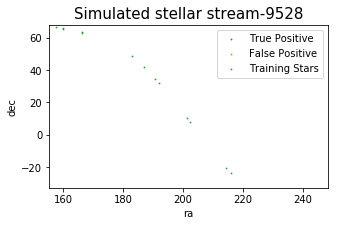

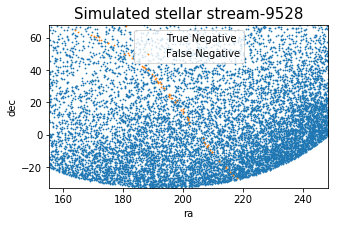

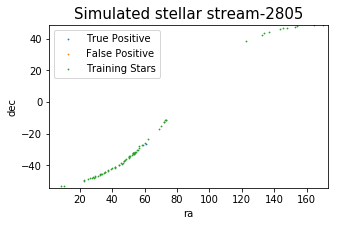

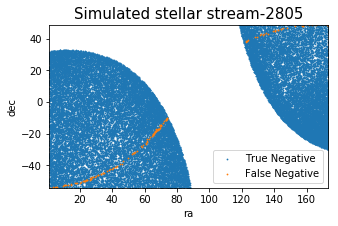

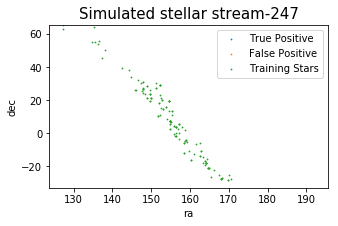

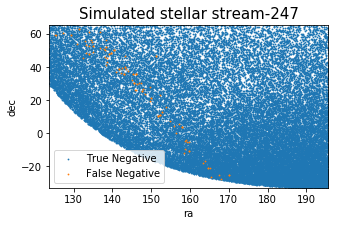

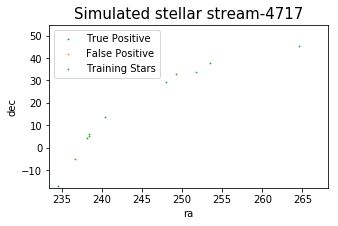

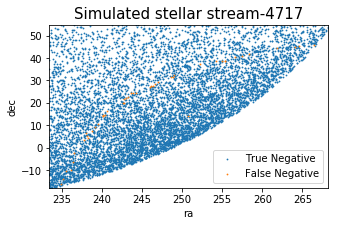

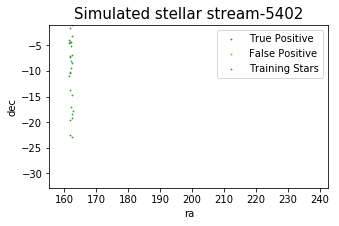

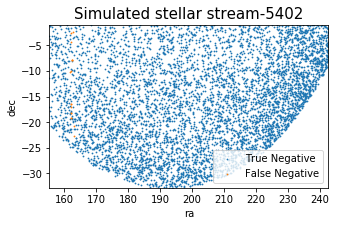

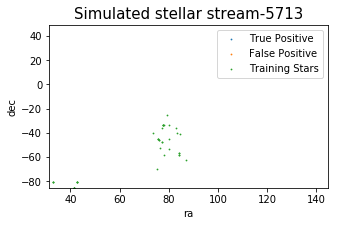

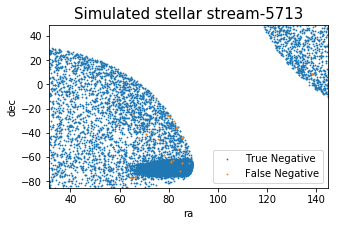

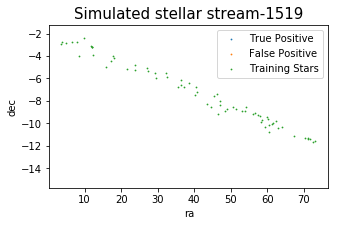

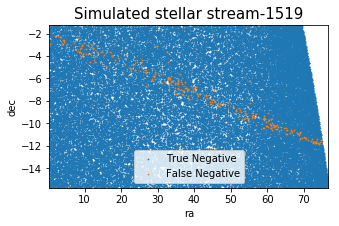

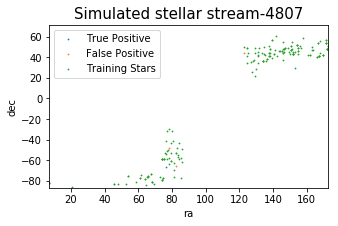

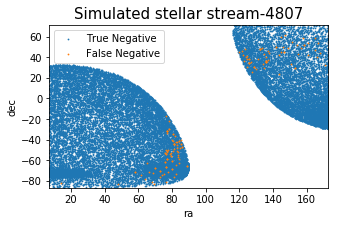

In [178]:
for item in range(len(viable_new2)):
    #Plot performance for Stream in index from 0 to len(streams)
    stream_index = item
    y_test = testing_datas[item].stream_mask
    y_pred = y_preds[item]
    #Truly in Cluster
    X_correct = testing_datas[item][y_test & y_pred] #predicted in cluster (true positives)
    X_incorrect = testing_datas[item][y_test & ~y_pred] #predicted not in cluster (false negative)
    #Truly not in Cluster
    X2_correct = testing_datas[item][~y_test & ~y_pred] #predicted not in cluster (true negative)
    X2_incorrect = testing_datas[item][~y_test & y_pred] #predicted in cluster (false positive)
    
    #Known to model
    known_to_model = training_datas[item]
    known_to_model_stream = known_to_model[known_to_model.stream_mask == True]
    known_to_model_back = known_to_model[known_to_model.stream_mask == False]

    X_correct['label']=1
    X_incorrect['label']=1
    X2_correct['label']=0
    X2_incorrect['label']=0
    
    size_plot = 0.6

    #visualize true and false positives
    plt.figure(figsize = (5,3))
    plt.scatter(X_correct['ra'], X_correct['dec'], label = "True Positive", s = size_plot)
    plt.scatter(X2_incorrect['ra'], X2_incorrect['dec'], label = "False Positive", s=size_plot)
    plt.scatter(known_to_model_stream['ra'], known_to_model_stream['dec'], label = 'Training Stars', s=size_plot)
    plt.xlabel('ra')
    plt.ylabel('dec')
    plt.title('Simulated stellar ' + viable_new[stream_index+9], fontsize = 15)
    plt.xlim(X2_correct['ra'].min(), X2_correct['ra'].max())
    plt.ylim(X2_correct['dec'].min(), X2_correct['dec'].max())
    plt.legend()

    plt.figure(figsize = (5,3))
    plt.scatter(X2_correct['ra'], X2_correct['dec'], label = "True Negative", s=size_plot)
    plt.scatter(X_incorrect['ra'], X_incorrect['dec'], label = "False Negative", s=size_plot)
    #plt.scatter(known_to_model_back['ra'], known_to_model_back['dec'], label = 'Training Stars', s=size_plot)
    plt.xlabel('ra')
    plt.ylabel('dec')
    plt.title('Simulated stellar ' + viable_new[stream_index+9], fontsize = 15)    
    plt.xlim(X2_correct['ra'].min(), X2_correct['ra'].max())
    plt.ylim(X2_correct['dec'].min(), X2_correct['dec'].max())
    plt.legend()
